# Computer Vision, Lab 7:  Structure from Motion (SfM)

Today we'll look at a full structure from motion pipeline, which involves keypoint computation,
keyframe selection, two-frame reconstruction, and resectioning. Some references for today's material:
- https://www.opensfm.org/docs/building.html
- https://github.com/mapillary/OpenSfM
- Mastering OpenCV3 (Packtpub)
- Mastering OpenCV4 (Packtpub)

As it's a big task to put all these things together from scratch, we'll use the open source OpenSFM framework.

## Introduction

### Flow

The following flow diagram describes the processing in the SfM pipeline we will implement.

<img src="img/lab07-11.png" width="800"/>

### Calibrated rigs vs. SfM

The first distinction we should make is the difference between stereo (or indeed any multiview) and 3D reconstruction using calibrated rigs and SfM. A rig of two or more cameras assumes that we already know the motion between the cameras, while in SfM, we do not know what the motion is, and we need to find it. Calibrated rigs allow more accurate reconstruction of 3D geometry because there is no error in estimating the distances and rotations between the cameras, which are already known, and there is no scale ambiguity, which we already know exists in
any SfM. The first step in SfM, on the other hand, is finding the motion between the cameras.

### Triangulation

In most cases, we wish to obtain the geometry of the scene, for example, where objects are in relation to the cameras and what their form is. Having found the motion between the cameras picturing the same scene, we would then like to reconstruct the geometry, initially in the form of a point cloud by triangulation. Conceptualy, the rays through a camera's optical center and a point in the idealized image plane for different 2D projections of the same 3D point will intersect at the correct 3D point in the real world that is imaged in each camera. In practice, however, with noisy correspondences, the two rays will not strictly intersect (they will be "skew"),
and we will have to minimize some cost function to find the 3D point minimizing that cost. The situation is shown in the following diagram.

<img src="img/lab07-12.jfif" width="800"/>

### Two-view epiolar geometry

Assume we have two images of the same scene from different positions in space. Two useful mathematical objects are the fundamental matrix (denoted by $\mathtt{F}$) and the essential matrix (denoted by $\mathtt{E}$), which impose constraints on the positions of corresponding 2D points in two images of the scene. The essential matrix is actually a fundamental matrix for the special case of normalized points with calibrated cameras, and using the essential matrix rather than the fundamental matrix for unnomralized points will give us a metric rather than projective reconstruction of the scene. Assuming the same calibration matrix $\mathtt{K}$ for our two cameras and two corresponding (unnormalized) points $\mathbf{x}$ and $\mathbf{x}'$ represented by homogeneous 3-vectors, we have
$$\mathbf{x}^\top\mathtt{K}^{-\top} \mathtt{E} \mathtt{K}^{-1} \mathbf{x}' = 
  \hat{\mathbf{x}}^\top \mathtt{E} \hat{\mathbf{x}}' = 0.$$
As we've learned from exercises in class, OpenCV implments Nister's 5-point algorithm for $\mathtt{E}$ as the inner loop for RANSAC. This is encapsulated in the <tt>findEssentialMat()</tt> function. Factoring $\mathtt{E}$ and testing the four possible solutions for the rotation and translation of the two cameras will give us the rotation between the two cameras and the translation vector *scaled to unit length*. Remember that this scaling of the unknown translation to one unit represents the scale ambiguity inherent in structure from motion. To resolve it, we would have to find an additional real-world distance or other constraint on the solution.

### Point matching using rich feature descriptors

Feature extraction and descriptor matching is useful for many computer vision tasks, e.g., detecting the position and orientation of an object in an image or searching a big database of images for similar images given a query image. **Feature extraction** means selecting points in the image that can be uniquely identified in other views of the same scene and computing a descriptor for each of them. A descriptor is just a vector of numbers that describes the texture around a feature point in an image. Different methods give different length and data types for descriptor vectors. **Descriptor matching** is the process of finding a corresponding feature for one set in another using the descriptor. OpenCV provides powerful methods to support feature extraction and matching.

If we're using mathematical feature point extractors,
given an image sequence, we will obtain three elements: feature points for two images (ORB, AKAZE, SIFT, SURF), descriptors for them, and a matching between the two sets of features (bruteforce).

In OpenCV, the brute-force matcher performs cross-check filtering. A match is considered true if a feature of the first image matches a feature of the second image, and the reverse check also matches the feature of the second image with the feature of the first image. Another common filtering mechanism, used in the provided code, is to filter based on the fact that the two images are of the same scene and have a certain stereo-view relationship between them. In practice, the filter tries to robustly calculate the fundamental or essential matrix which we will learn about in the "Finding camera matrices" section and retain those feature pairs that correspond with this calculation with small errors.

An alternative to using rich features, such as ORB, is to use optical flow. It is possible to use optical flow instead of descriptor matching to find the required point matching between two images, while the rest of the SfM pipeline remains the same.

Likewise, yet another alternative to the use of rich features such as ORB or optical flow is to use a deep learning
model for correspondence estimation. Deep learning models trained on large correspondence datasets have the potential to outperform the algorithmic correspondence estimation methods but may need fine tuning to perform well
in environments they were not trained upon.

### Finding camera matrices

Once we have obtained matches between keypoints, we can calculate the essential matrix. However, we must first align our matching points into two arrays, where an index in one array corresponds to the same index in the other. This is required by the <tt>findEssentialMat()</tt> function mentioned in the "Two-view epipolar geometry" section above. Once we've used the essential matrix to rule out outlier correspondences, we are left with just the inlier correspondences. Here is an example:

<img src="img/lab07-13.jfif" width="800"/>

Next, given $\mathtt{E}$, we can obtain the relative pose of the two cameras, giving us
the camera matrices. We've already discussed the mathematics at length in class, but the OpenCV API makes things very easy for us
with the <code>recoverPose()</code> function, which we've already seen how to use to construct the camera matrix $\mathtt{P} = \mathtt{K} [\mathtt{R} \mid \mathbf{t}]$.

### Choosing the image pair to use first

Given we have more than two views of the scene, we must choose which of the two views we will start reconstruction from, picking two views that have many essential matrix inliers but relatively few *homography inliers*. If all of the matches between two views of a scene can be explained by a single homography, we essentially have a set of planar points and no 3D structure. For this reason, we'll compute a homography $\mathtt{H}$ between each pair of views and select the one with the lowest ratio of homography inliers to essential matrix inliers.

When we process a video sequentially, the process of finding a good pair of initial frames is part of the *keyframe selection* process.

### Reconstructing the scene

Next, we look at triangulation. In the class exercies, we used the DLT algorithm for $\mathbf{X}$ given $\mathtt{P}, \mathtt{P}', \mathbf{x},$ and $\mathbf{x}'$.
This was fine because we didn't have an noise in the correspondences. When we have noise, it is important to minimize reprojection error iteratively using DLT as a starting point followed by Levenburg-Marquardt nonlinear least squares.

Another deviation from the class exercise is that today we'll use normalized points throughout, so we don't have to worry about the image size and field of view.
For example, a 2D point $\mathbf{x}_1 = (160, 120, 1)^\top$ in a 320$\times$240 image might transform to $\hat{\mathbf{x}}_1 = (0, 0, 1)^\top$ depending on what $\mathtt{K}$ is. The OpenCV function <code>undistortPoints()</code> will perform this translation for us.

<img src="img/lab07-14.png" width="800"/>

### Reconstruction from many views

Now that we know how to recover the motion and scene geometry from two cameras, it would seem simple to get the parameters of additional cameras and more scene points simply by applying the same process. This matter is in fact not so simple, as we can only get a reconstruction that is upto scale, and each pair of pictures has a different scale.

There are a number of ways to correctly reconstruct the 3D scene data from multiple views. One way to achieve **camera pose estimation** or **camera resectioning**, is the **Perspective N-Point(PnP)** algorithm, where we try to solve for the position of a new camera using N 3D scene points, which we have already found and their respective 2D image points. Another way is to triangulate more points and see how they fit into our existing scene geometry; this will tell us the position of the new camera by means of **point cloud registration**. In this section, we will discuss using OpenCV's <code>solvePnP</code> functions that implements the first method.

## Building OpenSFM

Let's build the OpenSFM library. This will take a while.
The following should work if you're on Ubuntu 20.04 with Python 3.8.

    $ sudo apt-get install build-essential cmake git libatlas-base-dev \
           libeigen3-dev libgoogle-glog-dev libsuitesparse-dev python3-dev \
           curl vim python3-yaml libopencv-dev
    $ mkdir -p source ; cd source ; curl -L http://ceres-solver.org/ceres-solver-1.14.0.tar.gz \
           | tar xz ; cd ceres-solver-1.14.0 ; mkdir -p build ; cd build ; cmake \
           -DCMAKE_C_FLAGS=-fPIC -DCMAKE_CXX_FLAGS=-fPIC -DBUILD_EXAMPLES=OFF \
           -DBUILD_TESTING=OFF .. ; make -j4 ; sudo make install ; cd ../..
    $ git clone --recursive https://github.com/paulinus/opengv.git ; \
           cd opengv ; mkdir -p build ; cd build ; \
           cmake -DBUILD_TESTS=OFF -DBUILD_PYTHON=ON -DPYBIND11_PYTHON_VERSION=3.8 \
           -DPYTHON_INSTALL_DIR=/usr/local/lib/python3.8/dist-packages/ .. ; \
           make -j4 ; sudo make install ; cd ../..
    $ pip3 install scipy sphinx fpdf opencv-python pillow
    $ git clone --recursive https://github.com/mapillary/OpenSfM
    $ cd OpenSfM ; python3 setup.py build

You may be missing some Python modules that I already had installed, so let me know if I'm missing some requirements.

Once that's done, if all is well, you should be able to view the three images of the Berlin Cathedral in data/berlin. Then you can execute the SfM pipeline:

<code>OpenSfM$ ./bin/opensfm_run_all data/berlin</code>

It will take a while to run. If successful, you'll get many messages, ending with something like

<code>2021-07-09 06:25:43,545 INFO: Merging depthmaps</code>

and the result will be a JSON file data/berlin/reconstruction.meshed.json. You can visualize the reconstructed point cloud with

<code>OpenSfM$ python3 -m http.server</code>

then you can visit http://localhost:8000/viewer/legacy/reconstruction.html#file=/data/berlin/reconstruction.meshed.json to see the reconstructed cameras and point cloud.

If you see something like the image below, all is successful.

<img src="img/lab07-1.jpg" width="600"/>

A lot more detail is at the OpenSfM documentation page. We will use this information to see how to use OpenSfM properly in the rest of the session.

## Get video

Use one of the sample videos for the lab. You may prefer the daytime or nighttime video.
Extract the individual frames as follows:
<code>
OpenSfM$ cd data
OpenSfM/data$ mkdir lab7-frames
OpenSfM/data$ cd lab7-frames
OpenSfM/data/lab7-frames$ ffmpeg -i ~/Downloads/robot.mp4 frame%03d.png
</code>
You should get a bunch of frames from the original video with names such as <code>frame001.png</code>:

## Prepare a dataset for SfM

Now you'll want to select a sequence of keyframes from the video. We'll think about how to do this automatically later, but here let's do it manually. Use two viewers to step through the sequence and get a subset of the frames that contain motion with perhaps 80% overlap between subsequent frames:
<code>
OpenSfM/data/lab7-frames$ eog frame001.png &
OpenSfM/data/lab7-frames$ mkdir ../lab7-keyframes/
OpenSfM/data/lab7-frames$ cp frame010.png ../lab7-keyframes/
OpenSfM/data/lab7-frames$ eog ../lab7-keyframes/frame010.png &
OpenSfM/data/lab7-frames$ cp frame120.png ../lab7-keyframes/
OpenSfM/data/lab7-frames$ ...
</code>
I got 55 frames in this way. Take note of the motion blur, compression artifacts, reflections off the windows, and other issues. You may notice that image quality is much lower and that more frames per second are needed when the robot is turning.

Next, copy the Berlin dataset configuration to your project directory:

<code>
OpenSfM/data/lab7-frames$ cd ../lab7-keyframes
OpenSfM/data/lab7-keyframes$ cp ../berlin/config.yaml .
OpenSfM/data/lab7-keyframes$ mkdir images
OpenSfM/data/lab7-keyframes$ mv *.png images/
OpenSfM/data/lab7-keyframes$ cd ../..
OpenSfM$
</code>

## Try a run:

OpenSfM$ ./bin/opensfm_run_all data/lab7-keyframes
It will take a few minutes to obtain the reconstruction. You'll see that the system does the following:

1. Extracts keypoints from every keyframe
2. Tries to match keypoints between every pair of frames. You will probably observe the best matching for adjacent frames in the sequence.
3. Builds up a 3D reconstruction, beginning with two frames that have good matches then performing resectioning for the remaining frames.
4. Computes depth maps for each frame based on the 3D points' projections into the images.

The resulting 3D reconstruction can then be viewed.

<code>
OpenSfM$ python3 -m http.server
</code>

And then you can visit http://localhost:8000/viewer/legacy/reconstruction.html#file=/data/lab7-keyframes/reconstruction.json

Do you get a reasonable result? If not, try subsequences of the total keyframe sequence until you get something reasonable.

Once you have a reasonable sparse reconstruction, you can view the dense one:

<code>
OpenSfM$ sudo apt-get install meshlab
OpenSfM$ meslab data/lab7-keyframes/undistorted/depthmaps/merged.ply
</code>

You should be able to see something like this:

<img src="img/lab07-2.png" width="600"/>

The dense mesh makes clear that the reconstruction works better for objects that are far from the camera. Reflections seem to wreak havoc and lead to multiple false matches.

### Improvements

Perform some further experiments in attempts to get better 3D reconstructions from OpenSfM. Some things to try:

1. Change the parameter depthmap_min_consistent_views to 3 or more.
2. Check the undistorted versions of the images in data/lab7-keyframes/undistorted/images/. Do you think that the automatically extracted distortion parameters are working well? Try using OpenCV to undistort the images in advance using the results from intrinsic calibration we got in previous labs. Do you get better results?
3. Check the estimated camera parameters in data/lab7-keyframes/camera_models.json. Does it seem reasonable? Would giving your own parameters be better? Note that OpenSfM only uses a single focal length, which is assumed the same for x and y, while our calibration generated a camera matrix with fx = 807 and fy = 804. Is this a big enough difference to affect OpenSfM? Redo the undistortion but this time output undistorted images with a single focal length, and then provide this focal length to OpenSfM by copying camera_models.json to camera_models_overrides.json prior to reconstruction. Note that the OpenSfM focal length fsfm is related to the OpenCV focal length fcv by fsfm = 2 * fcv / w, where w is the image width (1920 in our case).

### Thought experiments

Consider the following, discuss in your report, and make some recommendations:

1. The biggest bottleneck to the reconstruction was extracting keyframes. Think about how you could write a program to automatically extract keyframes using, for example, the Lucas and Kanade optical flow method we looked at in the early labs. What would you require of the optical flow between keyframe i and keyframe i+1 ? For some ideas, see our VISAPP paper on the subject and other references you find online.

2. Reflections on the floor seem to cause trouble for reconstruction, and the textureless floor surface means we almost never get good matches for points on the floor. Discuss how we could use our semantic segmentation model for floor/no-floor to automatically ignore the floor in the SfM (think about the masks provided for the Berlin Cathedral dataset), and also think about how, once we have the extrinsic parameters and scene scale, we could reconstruct a dense 3D mesh for the floor.

## Implementing SfM in OpenCV

To further understand what OpenSFM is doing, we'll also go into the SfM process in more detail using OpenCV. This material is from: *Mastering OpenCV4* by
Packtpub. Note that images and some of the text are taken directly from the original source. This tutorial seems to only work in Linux.

OpenCV has an abundance of tools to implement a full-fledged SfM pipeline from first principles. The "sfm" module allows us to get away with simply providing a non-parametric function with a list of images to crunch and receive a fully reconstructed scene with a sparse point cloud and camera poses. However, we will not take that route -- instead, we will see some useful methods that will allow us to have much more control over the reconstruction and exemplify some of the topics discussed in class and in previous sections of this lab manual.

This section will begin with the very basics of SfM: matching images using key points and feature descriptors. We will then advance to finding tracks, and multiple views of similar features through the image set, using a match graph. We proceed with 3D reconstruction, 3D visualization, and finally MVS with OpenMVS.

## Image feature matching

SfM, as presented above, relies on the understanding of the geometric relationship between images as it pertains to the visible objects in them. We saw that we can calculate the exact motion between two images with sufficient information on how the objects in the images move. The essential matrix, which can be estimated linearly from image features, can be decomposed to obtain the rotation and translation elements that define a 3D rigid transform. Thereafter, this transform can help us triangulate 3D positions of points, from the 3D-2D projection equations or from a dense stereo matching over rectified epilines. It all begins with image feature matching, so we will see how to obtain robust and noise-free matching.

OpenCV has an extensive offering of 2D feature detectors (also called extractors) and descriptors. Features are designed to be invariant to image deformations so they can be matched through translation, rotation, scaling, and other more complicated transformations (affine, projective) of the objects in the scene. One of the latest additions to OpenCV's APIs is the AKAZE feature extractor and detector, which presents a very good compromise between speed of calculation and robustness to transformation. AKAZE was shown to outperform other prominent features, such as ORB (short for Oriented BRIEF) and SURF (short for Speeded Up Robust Features).

The following snippet will extract a set of AKAZE keypoints and calculate AKAZE feature descriptors for each of the images we collect in <tt>imagesFilenames</tt>, and save them in the keypoints and descriptors arrays respectively:

    auto detector = AKAZE::create();
    auto extractor = AKAZE::create();

    for (const auto& i : imagesFilenames) {
        Mat grayscale;
        cvtColor(images[i], grayscale, COLOR_BGR2GRAY);
        detector->detect(grayscale, keypoints[i]);
        extractor->compute(grayscale, keypoints[i], descriptors[i]);

        CV_LOG_INFO(TAG, "Found " + to_string(keypoints[i].size()) + " 
        keypoints in " + i);
    }

Note we also convert the images to grayscale; however, this step may be omitted and the results will not suffer.

Here's a visualization of the detected features in two adjacent images. Notice how many of them repeat; this is known as feature repeatability, which is one of the most desired functions in a good feature extractor:

<img src="img/lab07-3.png" width="800"/>

Next up is matching the features between every pair of images. OpenCV provides an excellent feature matching suite. AKAZE feature descriptors are binary, meaning they cannot be regarded as binary-encoded numbers when matched; they must be compared on the bit level with bit-wise operators. OpenCV offers a Hamming distance metric for binary feature matchers, which essentially count the number of incorrect matches between the two-bit sequences:

    vector<DMatch> matchWithRatioTest(const DescriptorMatcher& matcher, 
                                      const Mat& desc1, 
                                      const Mat& desc2) 
    {
        // Raw match
        vector< vector<DMatch> > nnMatch;
        matcher.knnMatch(desc1, desc2, nnMatch, 2);

        // Ratio test filter
        vector<DMatch> ratioMatched;
        for (size_t i = 0; i < nnMatch.size(); i++) {
            const DMatch first = nnMatch[i][0];
            const float dist1 = nnMatch[i][0].distance;
            const float dist2 = nnMatch[i][1].distance;

            if (dist1 < MATCH_RATIO_THRESHOLD * dist2) {
                ratioMatched.push_back(first);
            }
        }

        return ratioMatched;
    }

The preceding function not only invokes our matcher (for example, a BFMatcher(NORM_HAMMING)) regularly, it also performs the ratio test. This simple test is a very fundamental concept in many computer vision algorithms that rely on feature matching (such as SfM, panorama stitching, sparse tracking, and more). Instead of looking for a single match for a feature from image A in image B, we look for two matches in image B and make sure there is no confusion. Confusion in matching may arise if two potential matching-feature descriptors are too similar (in terms of their distance metric) and we cannot tell which of them is the correct match for the query, so we discard them both to prevent confusion.

Next, we implement a reciprocity filter. This filter only allows feature matches that match (with a ratio test) in A to B, as well as B to A. Essentially, this is making sure there's a one-to-one match between features in image A and those in image B: a symmetric match. The reciprocity filter removes even more ambiguity and contributes to a cleaner, more robust match:

    // Match with ratio test filter
    vector<DMatch> match = matchWithRatioTest(matcher, descriptors[imgi], descriptors[imgj]);

    // Reciprocity test filter
    vector<DMatch> matchRcp = matchWithRatioTest(matcher, descriptors[imgj], descriptors[imgi]);
    vector<DMatch> merged;
    for (const DMatch& dmrecip : matchRcp) {
        bool found = false;
        for (const DMatch& dm : match) {
            // Only accept match if 1 matches 2 AND 2 matches 1.
            if (dmrecip.queryIdx == dm.trainIdx and dmrecip.trainIdx == 
            dm.queryIdx) {
                merged.push_back(dm);
                found = true;
                break;
            }
        }
        if (found) {
            continue;
        }
    }

Lastly, we apply the epipolar constraint. Every two images that have a valid rigid transformation between them would comply with the epipolar constraint over their feature points, , and those who don't pass this test (with sufficient success) are likely not a good match and may contribute to noise. We achieve this by calculating the fundamental matrix with a voting algorithm (RANSAC) and checking for the ratio of inliers to outliers. We apply a threshold to discard matches with a low survival rate with respect to the original match:

    // Fundamental matrix filter
    vector<uint8_t> inliersMask(merged.size());
    vector<Point2f> imgiPoints, imgjPoints;
    for (const DMatch& m : merged) {
        imgiPoints.push_back(keypoints[imgi][m.queryIdx].pt);
        imgjPoints.push_back(keypoints[imgj][m.trainIdx].pt);
    }
    findFundamentalMat(imgiPoints, imgjPoints, inliersMask);

    vector<DMatch> final;
    for (size_t m = 0; m < merged.size(); m++) {
        if (inliersMask[m]) {
            final.push_back(merged[m]);
        }
    }

    if ((float)final.size() / (float)match.size() < PAIR_MATCH_SURVIVAL_RATE) {
        CV_LOG_INFO(TAG, "Final match '" + imgi + "'->'" + imgj + "' has less than "+to_string(PAIR_MATCH_SURVIVAL_RATE)+" inliers from orignal. Skip");
        continue;
    }

We can see the effect of each of the filtering steps, raw match, ratio, reciprocity, and epipolar, in the following figure:

<img src="img/lab07-4.png" width="800"/>

### Finding feature tracks

The concept of feature tracks was introduced in SfM literature as early as 1992 in Tomasi and Kanade's work (Shape and Motion from Image Streams, 1992) and made famous in Snavely and Szeliski's seminal photo tourism work from 2007 for large-scale unconstrained reconstructions. Tracks are simply the 2D positions of a single scene feature, an interesting point, over a number of views. Tracks are important since they maintain consistency across frames than can be composed into a global optimization problem, as Snavely suggested. Tracks are specifically important to us since OpenCV's sfm module allows to reconstruct a scene by providing just the 2D tracks across all the views:

<img src="img/lab07-5.png" width="800"/>

Having already found a pair-wise match between all views, we have the required information to find tracks within those matched features. If we follow feature i in the first image to the second image through the match, then from the second image to the third image through their own match, and so on, we would end up with its track. This sort of bookkeeping can easily become too hard to implement in a straightforward fashion with standard data structures. However, it can be simply done if we represent all the matches in a match graph. Each node in the graph would be a feature detected in a single image, and edges would be the matches we recovered. From the feature nodes of the first image, we would have many edges to the feature nodes of the second image, third image, fourth image, and so on (for matches not discarded by our filters). Since our matches are reciprocal (symmetric), the graph can be undirected. Moreover, the reciprocity test ensures that for feature i in the first image, there is only one matching feature j in the second image, and vice versa: feature j will only match back to feature i.

The following is a visual example of such a match graph. The node colors represent the image from which the feature point (node) has originated. Edges represent a match between image features. We can notice the very strong pattern of a feature matching chain from the first image to the last:

<img src="img/lab07-6.png" width="800"/>

To code the match graph, we can use the Boost Graph Library (BGL), which has an extensive API for graph processing and algorithms. Constructing the graph is straightforward; we simply augment the nodes with the image ID and feature ID, so later we can trace back the origin:

    using namespace boost;

    struct ImageFeature {
        string image;
        size_t featureID;
    };
    typedef adjacency_list < listS, vecS, undirectedS, ImageFeature > Graph;
    typedef graph_traits < Graph >::vertex_descriptor Vertex;
    map<pair<string, int>, Vertex> vertexByImageFeature;

    Graph g;

    // Add vertices - image features
    for (const auto& imgi : keypoints) {
        for (size_t i = 0; i < imgi.second.size(); i++) {
            Vertex v = add_vertex(g);
            g[v].image = imgi.first;
            g[v].featureID = i;
            vertexByImageFeature[make_pair(imgi.first, i)] = v;
        }
    }

    // Add edges - feature matches
    for (const auto& match : matches) {
        for (const DMatch& dm : match.second) {
            Vertex& vI = vertexByImageFeature[make_pair(match.first.first, dm.queryIdx)];
            Vertex& vJ = vertexByImageFeature[make_pair(match.first.second, dm.trainIdx)];
            add_edge(vI, vJ, g);
        }
    }

Looking at a visualization of the resulting graph (using boost::write_graphviz()), we can see many cases where our matching is erroneous. A bad match chain will involve more than one feature from the same image in the chain. We marked a few such instances in the following figure; notice some chains have two or more nodes with the same color:

<img src="img/lab07-7.png" width="800"/>

We can notice the chains are essentially connected components in the graph. Extracting the components is simple using boost::connected_components():

    // Get connected components
    std::vector<int> component(num_vertices(gFiltered), -1);
    int num = connected_components(gFiltered, &component[0]);
    map<int, vector<Vertex> > components;
    for (size_t i = 0; i != component.size(); ++i) {
        if (component[i] >= 0) {
            components[component[i]].push_back(i);
        }
    }

We can filter out the bad components (with more than one feature from any one image) to get a clean match graph.

### 3D reconstruction and visualization

Having obtained the tracks in principle, we need to align them in a data structure that OpenCV's SfM module expects. Unfortunately, the sfm module is not very well documented, so this part we have to figure out on our own from the source code. We will be invoking the following function under the cv::sfm:: namespace, which can be found in opencv_contrib/modules/sfm/include/opencv2/sfm/reconstruct.hpp:

    void reconstruct(InputArrayOfArrays points2d, OutputArray Ps, OutputArray points3d, InputOutputArray K, bool is_projective = false);

The opencv_contrib/modules/sfm/src/simple_pipeline.cpp file has a major hint as to what that function expects as input:

    static void
    parser_2D_tracks( const std::vector<Mat> &points2d, libmv::Tracks &tracks )
    {
      const int nframes = static_cast<int>(points2d.size());
      for (int frame = 0; frame < nframes; ++frame) {
        const int ntracks = points2d[frame].cols;
        for (int track = 0; track < ntracks; ++track) {
          const Vec2d track_pt = points2d[frame].col(track);
          if ( track_pt[0] > 0 && track_pt[1] > 0 )
            tracks.Insert(frame, track, track_pt[0], track_pt[1]);
        }
      }
    } 

In general, the sfm module uses a reduced version of libmv (https://developer.blender.org/tag/libmv/), which is a well-established SfM package used for 3D reconstruction for cinema production with the Blender 3D (https://www.blender.org/) graphics software.

We can tell the tracks need to be placed in a vector of multiple individual cv::Mat, where each contains an aligned list of cv::Vec2d as columns, meaning it has two rows of double. We can also deduce that missing (unmatched) feature points in a track will have a negative coordinate. The following snippet will extract tracks in the desired data structure from the match graph:

    vector<Mat> tracks(nViews); // Initialize to number of views

    // Each component is a track
    const size_t nViews = imagesFilenames.size();
    tracks.resize(nViews);
    for (int i = 0; i < nViews; i++) {
        tracks[i].create(2, components.size(), CV_64FC1);
        tracks[i].setTo(-1.0); // default is (-1, -1) - no match
    }
    int i = 0;
    for (auto c = components.begin(); c != components.end(); ++c, ++i) {
        for (const int v : c->second) {
            const int imageID = imageIDs[g[v].image];
            const size_t featureID = g[v].featureID;
            const Point2f p = keypoints[g[v].image][featureID].pt;
            tracks[imageID].at<double>(0, i) = p.x;
            tracks[imageID].at<double>(1, i) = p.y;
        }
    }

We follow up with running the reconstruction function, collecting the sparse 3D point cloud and the color for each 3D point, and afterward, visualize the results (using functions from cv::viz::):

    cv::sfm::reconstruct(tracks, Rs, Ts, K, points3d, true);

This will produce a sparse reconstruction with a point cloud and camera positions, visualized in the following image:

<img src="img/lab07-8.png" width="800"/>

Re-projecting the 3D points back on the 2D images we can validate a correct reconstruction:

<img src="img/lab07-9.png" width="800"/>

See the entire code for reconstruction and visualization in the accompanying source repository.

Notice the reconstruction is very sparse; we only see 3D points where features have matched. This doesn't make for a very appealing effect when getting the geometry of objects in the scene. In many cases, SfM pipelines do not conclude with a sparse reconstruction, which is not useful for many applications, such as 3D scanning. Next, we will see how to get a dense reconstruction.

### MVS for dense reconstruction
With the sparse 3D point cloud and the positions of the cameras, we can proceed with dense reconstruction using MVS. We already learned the basic concept of MVS in the first section; however, we do not need to implement this from scratch, but rather we can use the OpenMVS project. To use OpenMVS for cloud densifying, we must save our project in a specialized format. OpenMVS provides a class for saving and loading .mvs projects, the MVS::Interface class, defined in MVS/Interface.h.

Let's start with the camera:

    MVS::Interface interface;
    MVS::Interface::Platform p;

    // Add camera
    MVS::Interface::Platform::Camera c;
    c.K = Matx33d(K_); // The intrinsic matrix as refined by the bundle adjustment
    c.R = Matx33d::eye(); // Camera doesn't have any inherent rotation
    c.C = Point3d(0,0,0); // or translation
    c.name = "Camera1";
    const Size imgS = images[imagesFilenames[0]].size();
    c.width = imgS.width; // Size of the image, to normalize the intrinsics
    c.height = imgS.height;
    p.cameras.push_back(c);

When adding the camera poses (views), we must take care. OpenMVS expects to get the rotation and center of the camera, and not the camera pose matrix for point projection $[R|t]$. We therefore must translate the translation vector to represent the center of the camera by applying the inverse rotation $-R^tt$:

    // Add views
    p.poses.resize(Rs.size());
    for (size_t i = 0; i < Rs.size(); ++i) {
        Mat t = -Rs[i].t() * Ts[i]; // Camera *center*
        p.poses[i].C.x = t.at<double>(0);
        p.poses[i].C.y = t.at<double>(1);
        p.poses[i].C.z = t.at<double>(2);
        Rs[i].convertTo(p.poses[i].R, CV_64FC1);

        // Add corresponding image (make sure index aligns)
        MVS::Interface::Image image;
        image.cameraID = 0;
        image.poseID = i;
        image.name = imagesFilenames[i];
        image.platformID = 0;
        interface.images.push_back(image);
    }
    p.name = "Platform1";
    interface.platforms.push_back(p);

After adding the point cloud to the Interface as well, we can proceed with the cloud densifying in the command line:

    $ ${openMVS}/build/bin/DensifyPointCloud -i crazyhorse.mvs
    18:48:32 [App ] Command line: -i crazyhorse.mvs
    18:48:32 [App ] Camera model loaded: platform 0; camera 0; f 0.896x0.896; poses 7
    18:48:32 [App ] Image loaded 0: P1000965.JPG
    18:48:32 [App ] Image loaded 1: P1000966.JPG
    18:48:32 [App ] Image loaded 2: P1000967.JPG
    18:48:32 [App ] Image loaded 3: P1000968.JPG
    18:48:32 [App ] Image loaded 4: P1000969.JPG
    18:48:32 [App ] Image loaded 5: P1000970.JPG
    18:48:32 [App ] Image loaded 6: P1000971.JPG
    18:48:32 [App ] Scene loaded from interface format (11ms):
    7 images (7 calibrated) with a total of 5.25 MPixels (0.75 MPixels/image)
    1557 points, 0 vertices, 0 faces
    18:48:32 [App ] Preparing images for dense reconstruction completed: 7 images (125ms)
    18:48:32 [App ] Selecting images for dense reconstruction completed: 7 images (5ms)
    Estimated depth-maps 7 (100%, 1m44s705ms)
    Filtered depth-maps 7 (100%, 1s671ms)
    Fused depth-maps 7 (100%, 421ms)
    18:50:20 [App ] Depth-maps fused and filtered: 7 depth-maps, 1653963 depths, 263027 points (16%%) (1s684ms)
    18:50:20 [App ] Densifying point-cloud completed: 263027 points (1m48s263ms)
    18:50:21 [App ] Scene saved (489ms):
    7 images (7 calibrated)
    263027 points, 0 vertices, 0 faces
    18:50:21 [App ] Point-cloud saved: 263027 points (46ms)


This process might take a few minutes to complete. However, once it's done, the results are very impressive. The dense point cloud has a whopping 263,027 3D points, compared to just 1,557 in the sparse cloud. We can visualize the dense OpenMVS project using the Viewer app bundled in OpenMVS:

<img src="img/lab07-10.png" width="800"/>

OpenMVS has several more functions to complete the reconstruction, such as extracting a triangular mesh from the dense point cloud.

You can load image samples from <link>[here](img/crazyhorse)</link>

## C++ full code

Here's the full C++ code:

    #include <iostream>
    #include <algorithm>
    #include <string>
    #include <numeric>

    #define CERES_FOUND true

    #include <opencv2/opencv.hpp>
    #include <opencv2/sfm.hpp>
    #include <opencv2/viz.hpp>
    #include <opencv2/core/utils/logger.hpp>
    #include <opencv2/core/utils/filesystem.hpp>
    #include <opencv2/xfeatures2d.hpp>

    #include <boost/filesystem.hpp>
    #include <boost/graph/graph_traits.hpp>
    #include <boost/graph/adjacency_list.hpp>
    #include <boost/graph/connected_components.hpp>
    #include <boost/graph/graphviz.hpp>

    #define _USE_OPENCV true
    #include <libs/MVS/Interface.h>

    using namespace cv;
    using namespace std;
    namespace fs = boost::filesystem;

    class StructureFromMotion {

    public:
        StructureFromMotion(const string& dir,
                const float matchSurvivalRate = 0.5f,
                const bool viz = false,
                const string mvs = "",
                const string cloud = "",
                const bool saveDebug = false)
            :PAIR_MATCH_SURVIVAL_RATE(matchSurvivalRate),
             visualize(viz),
             saveMVS(mvs),
             saveCloud(cloud),
             saveDebugVisualizations(saveDebug)

        {
            findImagesInDiretcory(dir);
        }

        void runSfM() {
            extractFeatures();
            matchFeatures();
            buildTracks();
            reconstructFromTracks();
            if (visualize) {
                visualize3D();
            }
            if (saveMVS != "") {
                saveToMVSFile();
            }
            if (saveCloud != "") {
                CV_LOG_INFO(TAG, "Save point cloud to: " + saveCloud);
                viz::writeCloud(saveCloud, pointCloud, pointCloudColor);
            }
        }

    private:
        void findImagesInDiretcory(const string& dir) {
            CV_LOG_INFO(TAG, "Finding images in " + dir);

            utils::fs::glob(dir, "*.jpg", imagesFilenames);
            utils::fs::glob(dir, "*.JPG", imagesFilenames);
            utils::fs::glob(dir, "*.png", imagesFilenames);
            utils::fs::glob(dir, "*.PNG", imagesFilenames);

            std::sort(imagesFilenames.begin(), imagesFilenames.end());

            CV_LOG_INFO(TAG, "Found " + std::to_string(imagesFilenames.size()) + " images");

            CV_LOG_INFO(TAG, "Reading images...");
            for (const auto& i : imagesFilenames) {
                CV_LOG_INFO(TAG, i);
                images[i] = imread(i);
                imageIDs[i] = images.size() - 1;
            }
        }

        void extractFeatures() {
            CV_LOG_INFO(TAG, "Extract Features");

            auto detector = AKAZE::create();
            auto extractor = AKAZE::create();

            for (const auto& i : imagesFilenames) {
                Mat grayscale;
                cvtColor(images[i], grayscale, COLOR_BGR2GRAY);
                detector->detect(grayscale, keypoints[i]);
                extractor->compute(grayscale, keypoints[i], descriptors[i]);

                CV_LOG_INFO(TAG, "Found " + to_string(keypoints[i].size()) + " keypoints in " + i);

                if (saveDebugVisualizations) {
                    Mat out;
                    drawKeypoints(images[i], keypoints[i], out, Scalar(0,0,255));
                    imwrite(fs::basename(fs::path(i)) + "_features.jpg", out);
                }
            }
        }

        vector<DMatch> matchWithRatioTest(const DescriptorMatcher& matcher, const Mat& desc1, const Mat& desc2) {
            // Raw match
            vector< vector<DMatch> > nnMatch;
            matcher.knnMatch(desc1, desc2, nnMatch, 2);

            // Ratio test filter
            vector<DMatch> ratioMatched;
            for (size_t i = 0; i < nnMatch.size(); i++) {
                DMatch first = nnMatch[i][0];
                float dist1 = nnMatch[i][0].distance;
                float dist2 = nnMatch[i][1].distance;

                if (dist1 < MATCH_RATIO_THRESHOLD * dist2) {
                    ratioMatched.push_back(first);
                }
            }

            return ratioMatched;
        }

        void matchFeatures() {
            CV_LOG_INFO(TAG, "Match Features");

            BFMatcher matcher(NORM_HAMMING);

            for (size_t i = 0; i < imagesFilenames.size() - 1; ++i) {
                for (size_t j = i + 1; j < imagesFilenames.size(); ++j) {
                    const string imgi = imagesFilenames[i];
                    const string imgj = imagesFilenames[j];

                    // Match with ratio test filter
                    vector<DMatch> match = matchWithRatioTest(matcher, descriptors[imgi], descriptors[imgj]);

                    // Reciprocity test filter
                    vector<DMatch> matchRcp = matchWithRatioTest(matcher, descriptors[imgj], descriptors[imgi]);
                    vector<DMatch> merged;
                    for (const DMatch& dmr : matchRcp) {
                        bool found = false;
                        for (const DMatch& dm : match) {
                            // Only accept match if 1 matches 2 AND 2 matches 1.
                            if (dmr.queryIdx == dm.trainIdx and dmr.trainIdx == dm.queryIdx) {
                                merged.push_back(dm);
                                found = true;
                                break;
                            }
                        }
                        if (found) {
                            continue;
                        }
                    }

                    // Fundamental matrix filter
                    vector<uint8_t> inliersMask(merged.size());
                    vector<Point2f> imgiPoints, imgjPoints;
                    for (const auto& m : merged) {
                        imgiPoints.push_back(keypoints[imgi][m.queryIdx].pt);
                        imgjPoints.push_back(keypoints[imgj][m.trainIdx].pt);
                    }
                    findFundamentalMat(imgiPoints, imgjPoints, inliersMask);

                    vector<DMatch> final;
                    for (size_t m = 0; m < merged.size(); m++) {
                        if (inliersMask[m]) {
                            final.push_back(merged[m]);
                        }
                    }

                    if ((float)final.size() / (float)match.size() < PAIR_MATCH_SURVIVAL_RATE) {
                        CV_LOG_INFO(TAG, "Final match '" + imgi + "'->'" + imgj + "' has less than "+to_string(PAIR_MATCH_SURVIVAL_RATE)+" inliers from orignal. Skip");
                        continue;
                    }

                    matches[make_pair(imgi, imgj)] = final;

                    CV_LOG_INFO(TAG, "Matching " + imgi + " and " + imgj + ": " + to_string(final.size()) + " / " + to_string(match.size()));

                    if (saveDebugVisualizations) {
                        Mat out;
                        vector<DMatch> rawmatch;
                        matcher.match(descriptors[imgi], descriptors[imgj], rawmatch);
                        vector<pair<string, vector<DMatch>& > > showList{
                                {"Raw Match", rawmatch},
                                {"Ratio Test Filter", match},
                                {"Reciprocal Filter", merged},
                                {"Epipolar Filter", final}
                        };
                        for (size_t i = 0; i< showList.size(); i++) {
                            drawMatches(images[imgi], keypoints[imgi],
                                        images[imgj], keypoints[imgj],
                                        showList[i].second, out, CV_RGB(255,0,0));
                            putText(out, showList[i].first, Point(10,50), FONT_HERSHEY_COMPLEX, 2.0, CV_RGB(255,255,255), 2);
                            putText(out, "# Matches: " + to_string(showList[i].second.size()), Point(10,100), FONT_HERSHEY_COMPLEX, 1.0, CV_RGB(255,255,255));
                            imwrite(fs::basename(fs::path(imgi)) + "_" + fs::basename(fs::path(imgj)) + "_" + to_string(i) + ".jpg", out);
                        }
                    }
                }
            }
        }

        void buildTracks() {
            CV_LOG_INFO(TAG, "Build tracks");

            using namespace boost;

            struct ImageFeature {
                string image;
                size_t featureID;
            };
            typedef adjacency_list < listS, vecS, undirectedS, ImageFeature > Graph;
            typedef graph_traits < Graph >::vertex_descriptor Vertex;

            map<pair<string, int>, Vertex> vertexByImageFeature;

            Graph g;

            // Add vertices - image features
            for (const auto& imgi : keypoints) {
                for (size_t i = 0; i < imgi.second.size(); i++) {
                    Vertex v = add_vertex(g);
                    g[v].image = imgi.first;
                    g[v].featureID = i;
                    vertexByImageFeature[make_pair(imgi.first, i)] = v;
                }
            }

            // Add edges - feature matches
            for (const auto& match : matches) {
                for (const DMatch& dm : match.second) {
                    Vertex& vI = vertexByImageFeature[make_pair(match.first.first, dm.queryIdx)];
                    Vertex& vJ = vertexByImageFeature[make_pair(match.first.second, dm.trainIdx)];
                    add_edge(vI, vJ, g);
                }
            }

            using Filtered  = filtered_graph<Graph, keep_all, std::function<bool(Vertex)>>;
            Filtered gFiltered(g, keep_all{}, [&g](Vertex vd) { return degree(vd, g) > 0; });

            // Get connected components
            std::vector<int> component(num_vertices(gFiltered), -1);
            int num = connected_components(gFiltered, &component[0]);
            map<int, vector<Vertex> > components;
            for (size_t i = 0; i != component.size(); ++i) {
                if (component[i] >= 0) {
                    components[component[i]].push_back(i);
                }
            }
            // Filter bad components (with more than 1 feature from a single image)
            std::vector<int> vertexInGoodComponent(num_vertices(gFiltered), -1);
            map<int, vector<Vertex> > goodComponents;
            for (const auto& c : components) {
                set<string> imagesInComponent;
                bool isComponentGood = true;
                for (int j = 0; j < c.second.size(); ++j) {
                    const string imgId = g[c.second[j]].image;
                    if (imagesInComponent.count(imgId) > 0) {
                        // Image already represented in this component
                        isComponentGood = false;
                        break;
                    } else {
                        imagesInComponent.insert(imgId);
                    }
                }
                if (isComponentGood) {
                    for (int j = 0; j < c.second.size(); ++j) {
                        vertexInGoodComponent[c.second[j]] = 1;
                    }
                    goodComponents[c.first] = c.second;
                }
            }

            Filtered gGoodComponents(g, keep_all{}, [&vertexInGoodComponent](Vertex vd) {
                return vertexInGoodComponent[vd] > 0;
            });

            CV_LOG_INFO(TAG, "Total number of components found: " + to_string(components.size()));
            CV_LOG_INFO(TAG, "Number of good components: " + to_string(goodComponents.size()));
            const int accum = std::accumulate(goodComponents.begin(),
                                              goodComponents.end(), 0,
                                              [](int a, pair<const int, vector<Vertex> >& v){
                                                        return a+v.second.size();
                                                    });
            CV_LOG_INFO(TAG, "Average component size: " + to_string((float)accum / (float)(goodComponents.size())));

            if (saveDebugVisualizations) {
                struct my_node_writer {
                    my_node_writer(Graph& g_, const map<string,int>& iid_) : g (g_), iid(iid_) {};
                    void operator()(std::ostream& out, Vertex v) {
                        const int imgId = iid[g[v].image];
                        out << " [label=\"" << imgId << "\" colorscheme=\"accent8\" fillcolor="<<(imgId+1)<<" style=filled]";
                    };
                    Graph g;
                    map<string,int> iid;
                };
                std::ofstream ofs("match_graph_good_components.dot");
                write_graphviz(ofs, gGoodComponents, my_node_writer(g, imageIDs));
                std::ofstream ofsf("match_graph_filtered.dot");
                write_graphviz(ofsf, gFiltered, my_node_writer(g, imageIDs));
            }

            // Each component is a track
            const size_t nViews = imagesFilenames.size();
            tracks.resize(nViews);
            for (int i = 0; i < nViews; i++) {
                tracks[i].create(2, goodComponents.size(), CV_64FC1);
                tracks[i].setTo(-1.0);
            }
            int i = 0;
            for (auto c = goodComponents.begin(); c != goodComponents.end(); ++c, ++i) {
                for (const int v : c->second) {
                    const int imageID = imageIDs[g[v].image];
                    const size_t featureID = g[v].featureID;
                    const Point2f p = keypoints[g[v].image][featureID].pt;
                    tracks[imageID].at<double>(0, i) = p.x;
                    tracks[imageID].at<double>(1, i) = p.y;
                }
            }

            if (saveDebugVisualizations) {
                vector<Scalar> colors = {CV_RGB(240, 248, 255),
                                         CV_RGB(250, 235, 215),
                                         CV_RGB(0, 255, 255),
                                         CV_RGB(127, 255, 212),
                                         CV_RGB(240, 255, 255),
                                         CV_RGB(245, 245, 220),
                                         CV_RGB(255, 228, 196),
                                         CV_RGB(255, 235, 205),
                                         CV_RGB(0, 0, 255),
                                         CV_RGB(138, 43, 226),
                                         CV_RGB(165, 42, 42),
                                         CV_RGB(222, 184, 135)};

                vector<Mat> imagesM;
                for (const auto m : images) imagesM.push_back(m.second);
                Mat out;
                hconcat(vector<Mat>(imagesM.begin(), imagesM.begin() + 4), out);
                RNG& rng = cv::theRNG();
                const Size imgS = imagesM[0].size();
                for (int tId = 0; tId < 20; tId++) {
                    const int trackId = rng(tracks[0].cols); // Randomize a track ID

                    // Show track over images
                    for (int i = 0; i < 3; i++) {
                        Point2f a = Point2f(tracks[i].col(trackId));
                        Point2f b = Point2f(tracks[i + 1].col(trackId));

                        if (a.x < 0 or a.y < 0 or b.x < 0 or b.y < 0) {
                            continue;
                        }

                        const Scalar c = colors[tId % colors.size()];
                        a.x += imgS.width * i;
                        b.x += imgS.width * (i + 1);
                        circle(out, a, 7, c, FILLED);
                        circle(out, b, 7, c, FILLED);
                        line(out, a, b, c, 3);
                    }
                    imwrite("tracks.jpg", out);

                    // Show track patches
                    const int patchSize = 20;
                    const Point2f patch(patchSize, patchSize);
                    for (int i = 0; i < tracks.size(); i++) {
                        Point2f a = Point2f(tracks[i].col(trackId));
                        if (a.x < patchSize or a.y < patchSize or
                            a.x > imgS.width-patchSize or a.y > imgS.height-patchSize) {
                            continue;
                        }

                        imwrite("track_" + to_string(trackId) + "_" + to_string(i) + ".png",
                                imagesM[i](Rect(a - patch, a + patch)));
                    }
                }
            }
        }

        bool reconstructFromTracks() {
            CV_LOG_INFO(TAG, "Reconstruct from " + to_string(tracks[0].cols) + " tracks");
            const Size imgS = images.begin()->second.size();
            const float f = std::max(imgS.width,imgS.height);
            Mat K = Mat(Matx33f{f, 0.0, imgS.width/2.0f,
                                0.0, f, imgS.height/2.0f,
                                0.0, 0.0, 1.0});
            cv::sfm::reconstruct(tracks, Rs, Ts, K, points3d, true);

            K.copyTo(K_);

            CV_LOG_INFO(TAG, "Reconstruction: ");
            CV_LOG_INFO(TAG, "Estimated 3D points: " + to_string(points3d.size()));
            CV_LOG_INFO(TAG, "Estimated cameras: " + to_string(Rs.size()));
            CV_LOG_INFO(TAG, "Refined intrinsics: ");
            CV_LOG_INFO(TAG, K_);

            if (Rs.size() != imagesFilenames.size()) {
                CV_LOG_ERROR(TAG, "Unable to reconstruct all camera views (" + to_string(imagesFilenames.size()) + ")");
                return false;
            }

            if (tracks[0].cols != points3d.size()) {
                CV_LOG_WARNING(TAG, "Unable to reconstruct all tracks (" + to_string(tracks[0].cols) + ")");
            }

            // Create the point cloud
            pointCloud.clear();
            for (const auto &p : points3d) pointCloud.emplace_back(Vec3f(p));

            // Get the point colors
            pointCloudColor.resize(pointCloud.size(), Vec3b(0,255,0));
            vector<Point2f> point2d(1);
            for (int i = 0; i < (int)pointCloud.size(); i++) {
                for (int j = 0; j < imagesFilenames.size(); ++j) {
                    Mat point3d = Mat(pointCloud[i]).reshape(1, 1);
                    cv::projectPoints(point3d, Rs[j], Ts[j], K_, Mat(), point2d);
                    if (point2d[0].x < 0 or point2d[0].x >= imgS.width or point2d[0].y < 0 or
                        point2d[0].y >= imgS.height) {
                        continue;
                    }
                    pointCloudColor[i] = images[imagesFilenames[j]].at<Vec3b>(point2d[0]);
                    break;
                }
            }

            return true;
        }

        void visualize3D() {
            CV_LOG_INFO(TAG, "Visualize reconstruction");

            if (saveDebugVisualizations) {
                // 3d point reprojections
                Mat points2d;
                Mat points3dM(points3d.size(), 1, CV_32FC3);
                for (int i = 0 ; i < points3d.size(); i++) {
                    points3dM.at<Vec3f>(i) = Vec3f(points3d[i]);
                }
                for (int j = 0; j < imagesFilenames.size(); j++) {
                    cv::projectPoints(points3dM, Rs[j], Ts[j], K_, noArray(), points2d);

                    Mat out;
                    images[imagesFilenames[j]].copyTo(out);
                    for (int i = 0; i < points2d.rows; i++) {
                        circle(out, points2d.at<Point2f>(i), 3, CV_RGB(255, 0, 0), FILLED);
                    }
                    imwrite("reprojection_" + to_string(j) + ".jpg", out);
                }
            }

            // Create 3D windows
            viz::Viz3d window("Coordinate Frame");
            window.setWindowSize(Size(500, 500));
            window.setWindowPosition(Point(150, 150));
            window.setBackgroundColor(viz::Color::white());

            // Recovering cameras
            vector<Affine3d> path;
            for (size_t i = 0; i < Rs.size(); ++i)
                path.push_back(Affine3d(Rs[i],Ts[i]));

            // Add the pointcloud
            viz::WCloud cloud_widget(pointCloud, pointCloudColor);
            window.showWidget("point_cloud", cloud_widget);
            // Add cameras
            window.showWidget("cameras_frames_and_lines", viz::WTrajectory(path, viz::WTrajectory::BOTH, 0.1, viz::Color::black()));
            window.showWidget("cameras_frustums", viz::WTrajectoryFrustums(path, K_, 0.1, viz::Color::navy()));
            window.setViewerPose(path[0]);

            /// Wait for key 'q' to close the window
            CV_LOG_INFO(TAG, "Press 'q' to close ... ")

            window.spin();
        }

        void saveToMVSFile() {
            CV_LOG_INFO(TAG, "Save reconstruction to MVS file: " + saveMVS)

            MVS::Interface interface;
            MVS::Interface::Platform p;

            // Add camera
            MVS::Interface::Platform::Camera c;
            const Size imgS = images[imagesFilenames[0]].size();
            c.K = Matx33d(K_);
            c.R = Matx33d::eye();
            c.C = Point3d(0,0,0);
            c.name = "Camera1";
            c.width = imgS.width;
            c.height = imgS.height;
            p.cameras.push_back(c);

            // Add views
            p.poses.resize(Rs.size());
            for (size_t i = 0; i < Rs.size(); ++i) {
                Mat t = -Rs[i].t() * Ts[i];
                p.poses[i].C.x = t.at<double>(0);
                p.poses[i].C.y = t.at<double>(1);
                p.poses[i].C.z = t.at<double>(2);
                Mat r; Rs[i].copyTo(r);
                Mat(r).convertTo(p.poses[i].R, CV_64FC1);

                // Add corresponding image
                MVS::Interface::Image image;
                image.cameraID = 0;
                image.poseID = i;
                image.name = imagesFilenames[i];
                image.platformID = 0;
                interface.images.push_back(image);
            }
            p.name = "Platform1";
            interface.platforms.push_back(p);

            // Add point cloud
            for (size_t k = 0; k < points3d.size(); ++k) {
                MVS::Interface::Color c;
                MVS::Interface::Vertex v;
                v.X = Vec3f(points3d[k]);

                // Reproject to see if in image bounds and get the RGB color
                Mat point3d;
                Mat(points3d[k].t()).convertTo(point3d, CV_32FC1);
                for (uint32_t j = 0; j < tracks.size(); ++j) {
                    vector<Point2f> points2d(1);
                    cv::projectPoints(point3d, Rs[j], Ts[j], K_, Mat(), points2d);
                    if (points2d[0].x < 0 or points2d[0].x > imgS.width or
                        points2d[0].y < 0 or points2d[0].y > imgS.height) {
                        continue;
                    } else {
                        c.c = images[imagesFilenames[j]].at<Vec3b>(points2d[0]);
                        v.views.push_back({j, 1.0});
                    }
                }

                interface.verticesColor.push_back(c);
                interface.vertices.push_back(v);
            }

            MVS::ARCHIVE::SerializeSave(interface, saveMVS);
        }

        vector<String> imagesFilenames;
        map<string, int> imageIDs;
        map<string, Mat> images;
        map<string, vector<KeyPoint> > keypoints;
        map<string, Mat> descriptors;
        map<pair<string, string>, vector<DMatch> > matches;
        vector<Mat> Rs, Ts;
        vector<Mat> points3d;
        vector<Mat> tracks;
        vector<Vec3f> pointCloud;
        vector<Vec3b> pointCloudColor;
        Matx33f K_;

        const float MATCH_RATIO_THRESHOLD = 0.8f; // Nearest neighbor matching ratio
        const float PAIR_MATCH_SURVIVAL_RATE;     // Ratio of surviving matches for a successful stereo match
        const bool visualize;                     // Show 3D visualization of the sprase cloud?
        const string saveMVS;                     // Save the reconstruction in MVS format for OpenMVS?
        const string saveCloud;                   // Save the reconstruction to a point cloud file?
        const bool saveDebugVisualizations;       // Save debug visualizations from the reconstruction process

        const string TAG = "StructureFromMotion";
    };


    int main(int argc, char** argv) {
        utils::logging::setLogLevel(utils::logging::LOG_LEVEL_DEBUG);

        cv::CommandLineParser parser(argc, argv,
                                     "{help h ? |           | help message}"
                                     "{@dir     | ./images  | directory with image files for reconstruction }"
                                     "{mrate    | 0.5       | Survival rate of matches to consider image pair success }"
                                     "{viz      | true      | Visualize the sparse point cloud reconstruction? }"
                                     "{debug    | false     | Save debug visualizations to files? }"
                                     "{mvs      | recon.mvs | Save reconstruction to an .mvs file. Provide filename }"
                                     "{cloud    | cloud.ply | Save reconstruction to a point cloud file (PLY, XYZ and OBJ). Provide filename}"
        );

        if (parser.has("help"))
        {
            parser.printMessage();
            return 0;
        }

        StructureFromMotion sfm(parser.get<string>("@dir"),
                                parser.get<float>("mrate"),
                                parser.get<bool>("viz"),
                                parser.get<string>("mvs"),
                                parser.get<string>("cloud"),
                                parser.get<bool>("debug")
                                );
        sfm.runSfM();

        return 0;
    }


## Exercises

1. Get the OpenCV C++ code running on the sample data from the Packt book's repository.
2. Try the same process on the keyframes you extracted from the robot video and compare the OpenSFM / OpenCV results.

## Report

Provide a brief report documenting your experiments with OpenSFM and the customized OpenCV processing stream on video data from the robot, due in Google Classroom
by next week's lab.


### Reconstruction results using OpenSfm
i) Using depthmap_min_consistent_views = 3<br>
ii) Using pre-undistorted images<br>
iii) Using pre-computed camera Parameters with a single focal length = 0.829

Reconstruction seems to give better results using minimum 3 consitent views and especially using pre-undistorted images. The results are marginally better when using a single focal length for pre-undistortion in the opencv and passing it as a parameter to the OpenSFM.

Blurry images, textureless images, and sections of video with fast motion are problematic for creating an accurate 3D recontruction. 

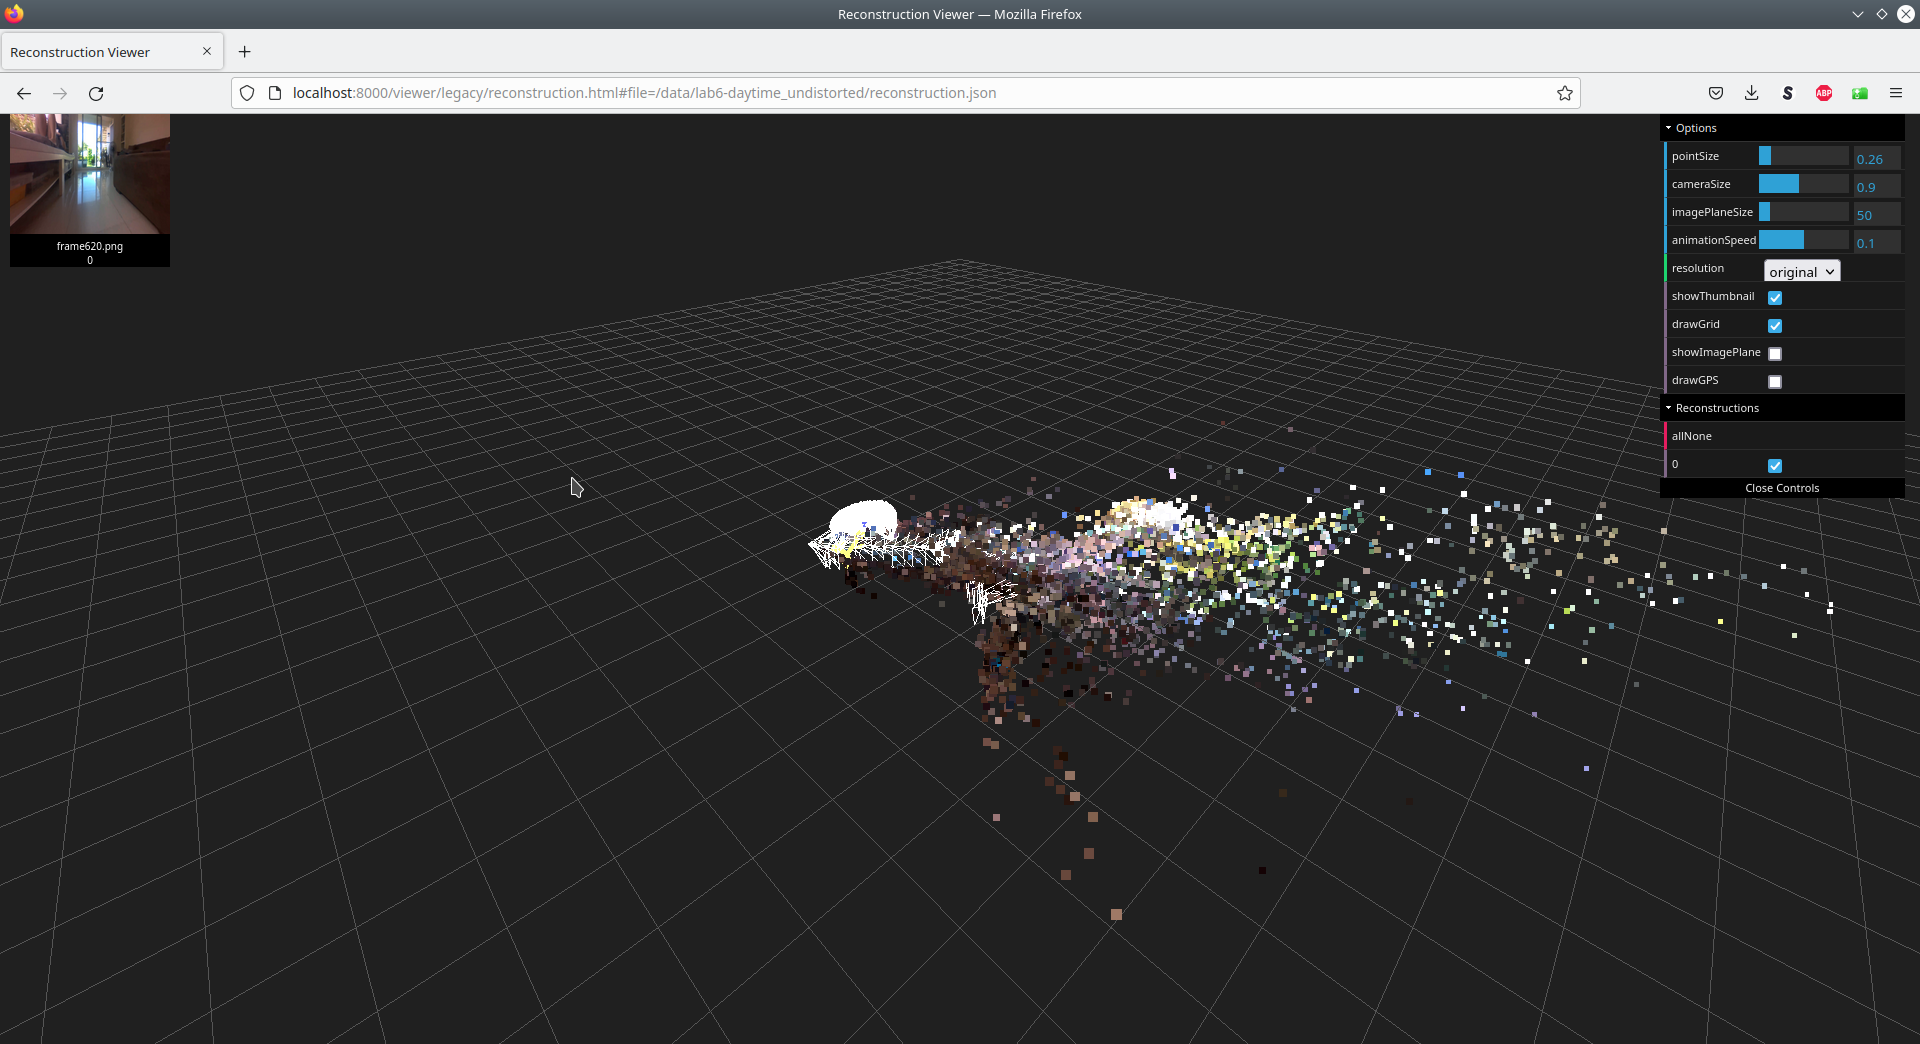

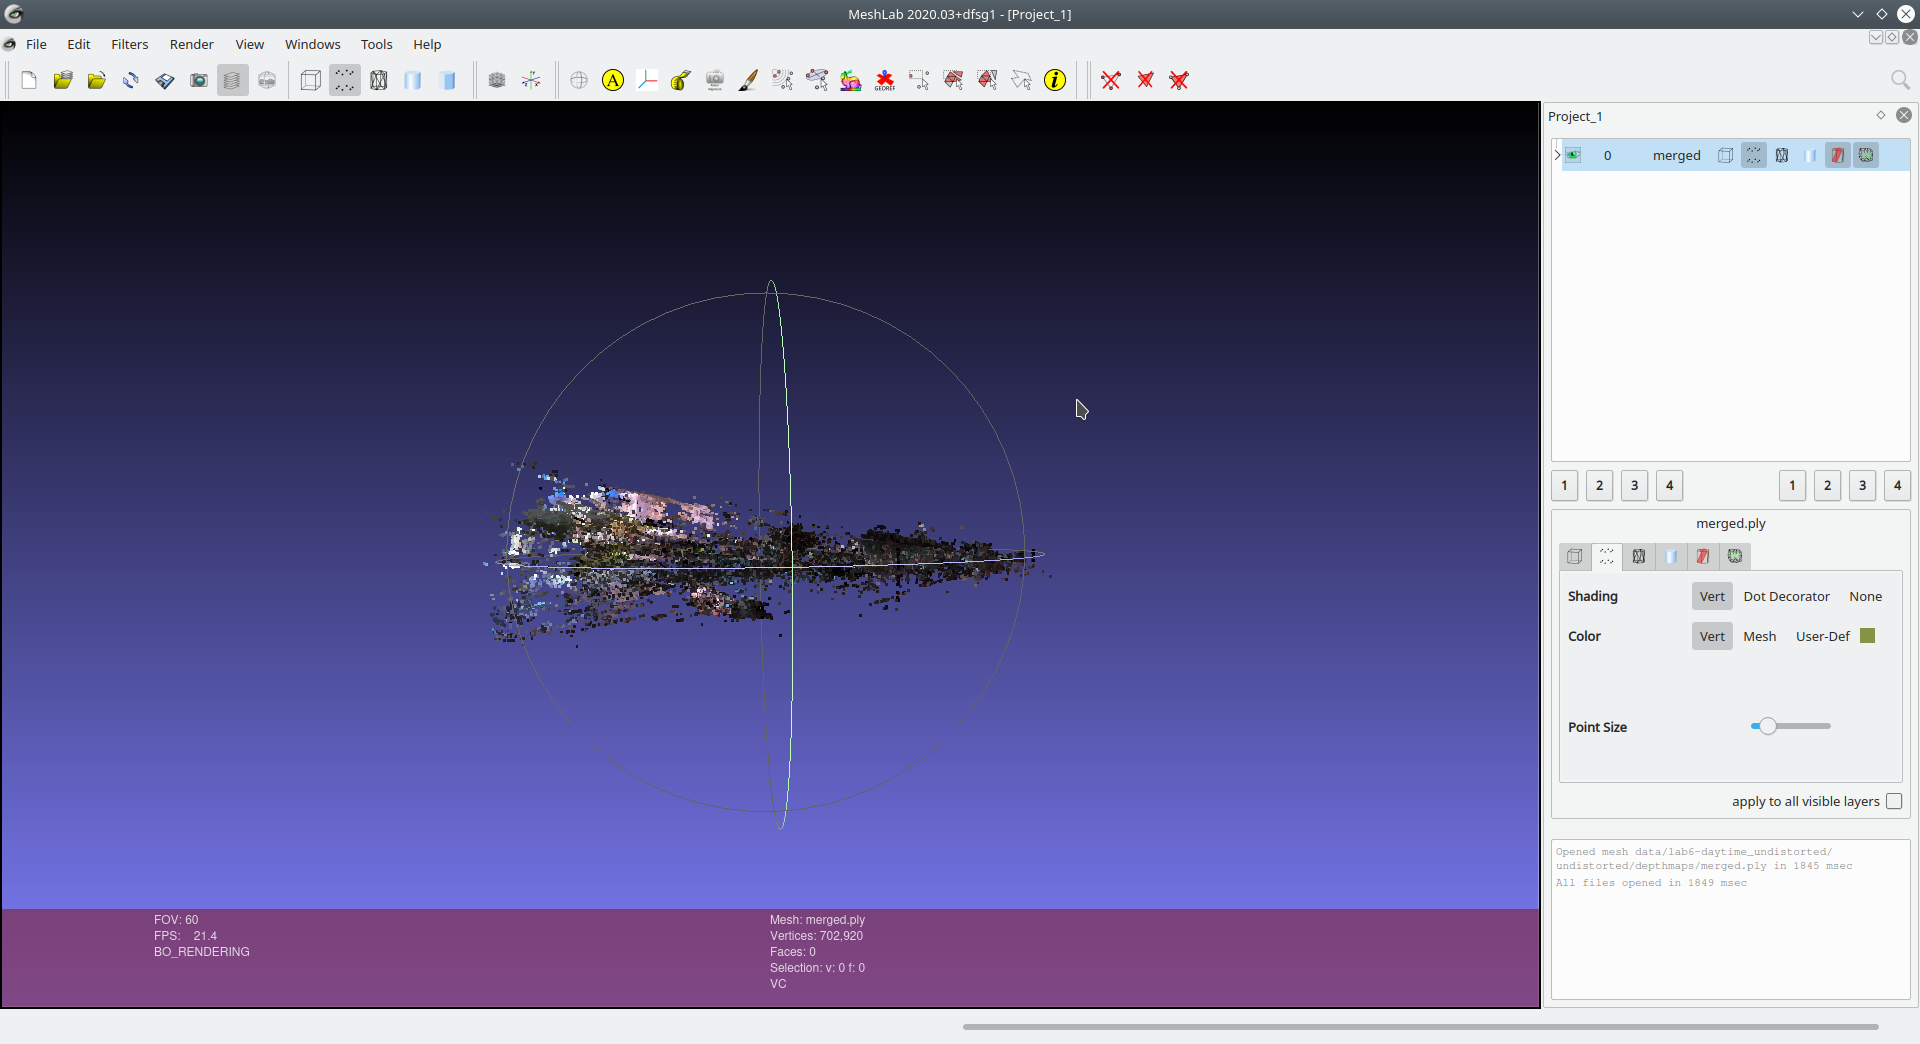

#### Automatic Keyframe Selection

We can use Optical Flow to get the keyframes from the video. Since we need the keyframes to represent some significant motion, we can choose the frames which represents the highest motion of the 3x3 patch used in Lucas-Kanade, while still giving good optical flow. The motion must not be too small as to make the keyframe reduntant, and it should not be too big such that we cannot calculate the optical flow. Then the candidate keyframes are examined based on some minimum threshold of mutual information entropy and the frames meeting the criteria are selected. Referenced from https://iopscience.iop.org/article/10.1088/1742-6596/1646/1/012112/pdf 

#### Floor Segmentation

We can easily use the floor mask predicted from our semantic segmentation model to segment out the floor from the image by using bit-wise AND operator between the predicted mask and the image. Then we can input the resulting image into the Sfm Pipeline. Once we have the camera parameters and the scene scale, we can use it for triangulation to compute an accurate 3D Mesh using the P matrices.

### OpenCV SFM

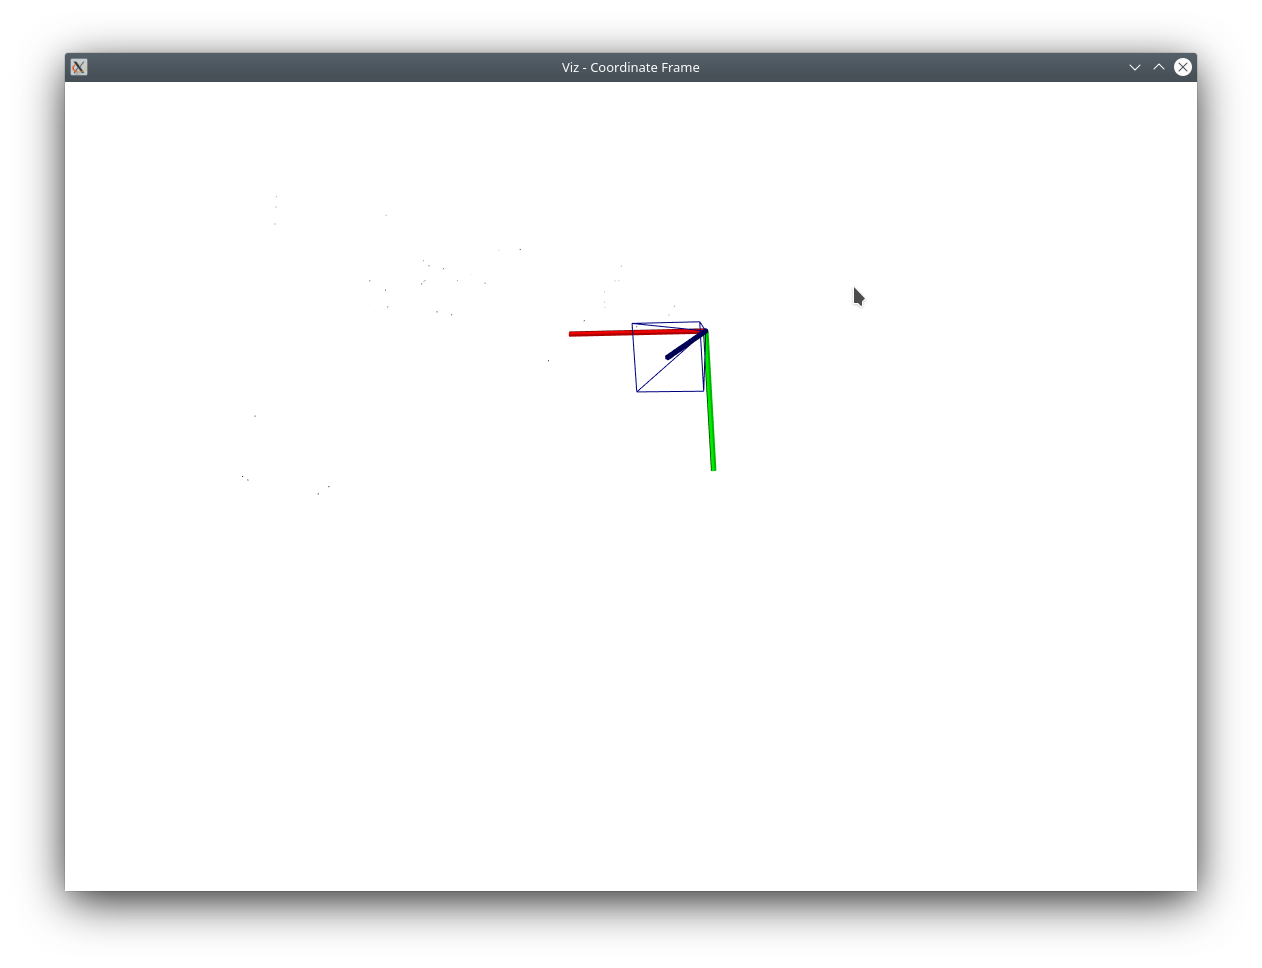

Using OpenCV SFM pipeline, the 3D reconstruction from the example images is below.

### Reconstruction using OpenCV

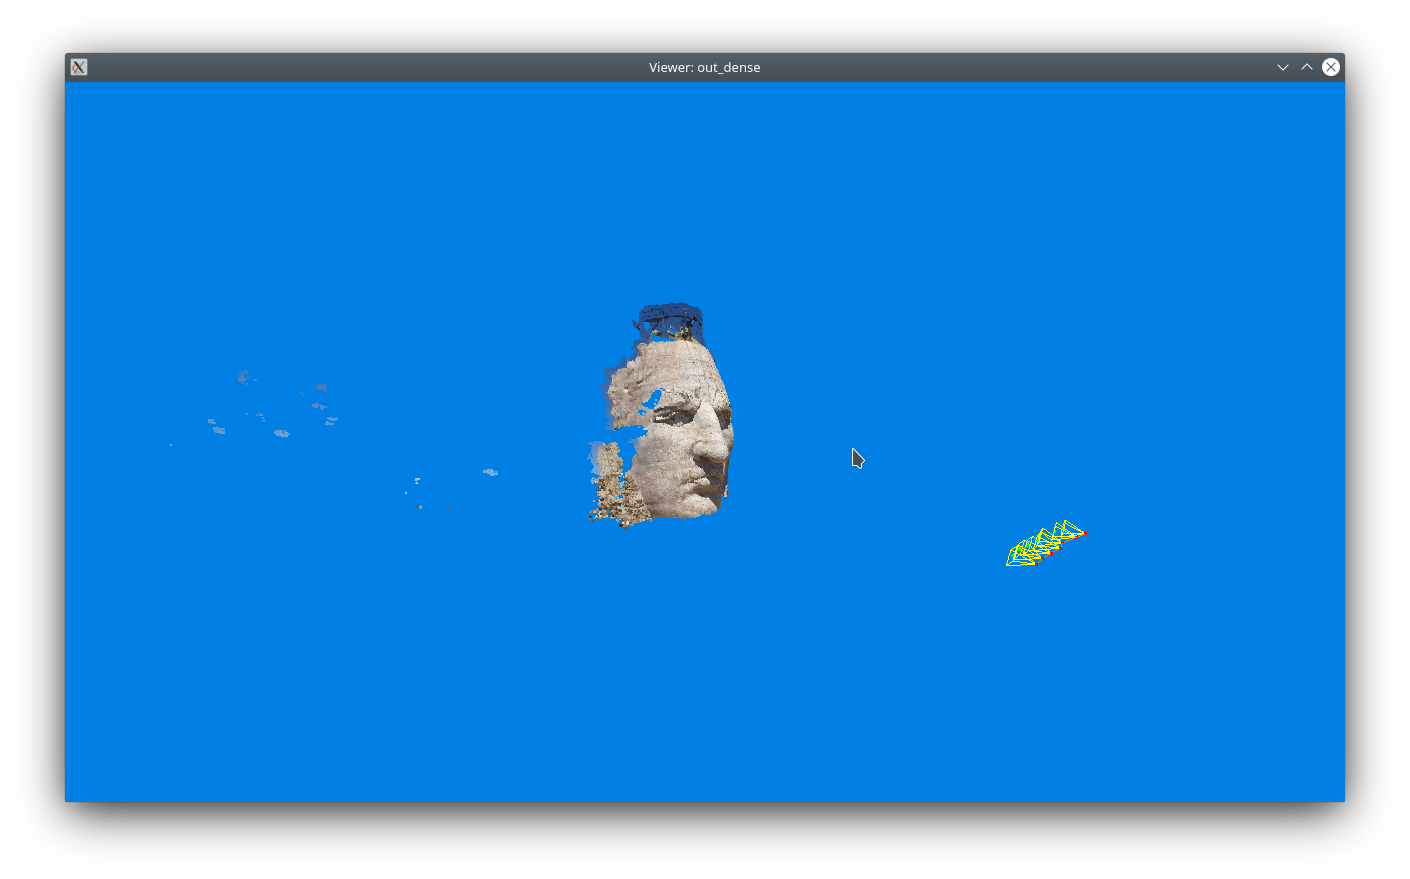

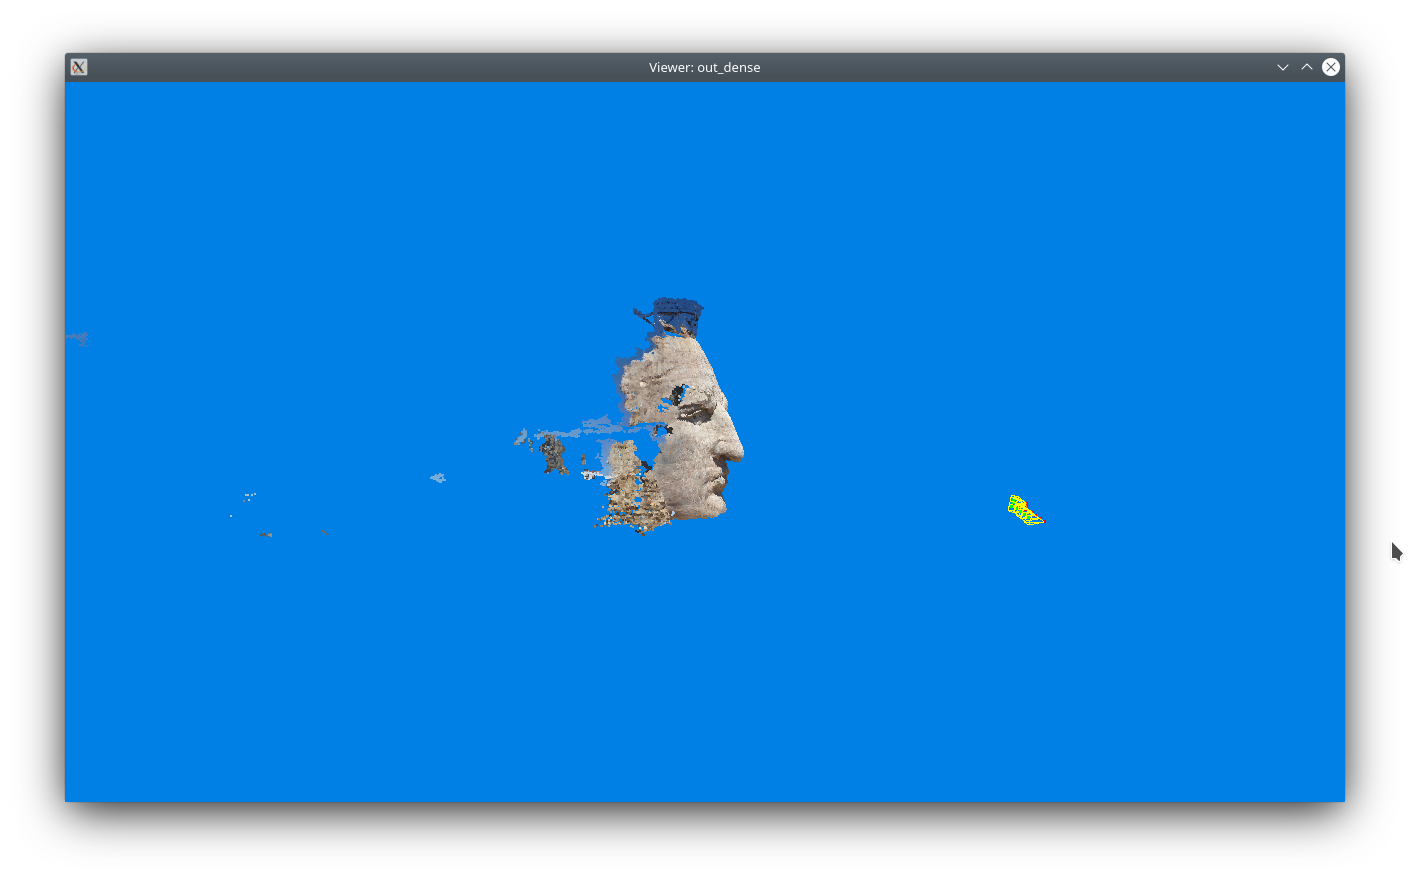

The opencv pipeline does not seem to work on the whole robot video povided in the lab. It seems to encounter a problem calculating the fundamental matrix. The same set of images seem to work fine with OpenSFM. It maybe due to the motion blur or large motion of the camera, where it is not able to detect the keypoints. For a subset of the images it seems to converge. The reconstruction is below.

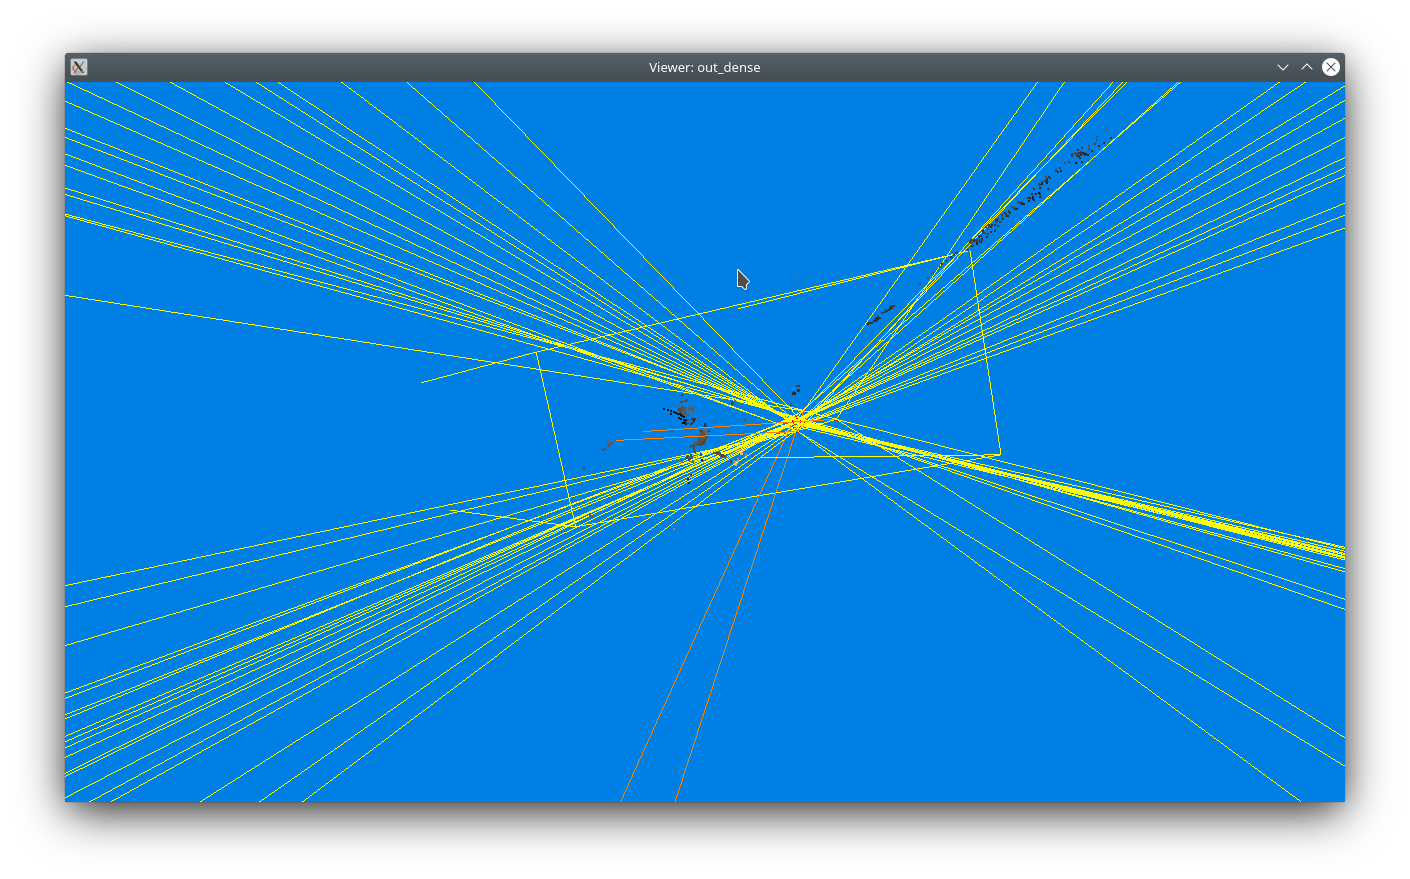

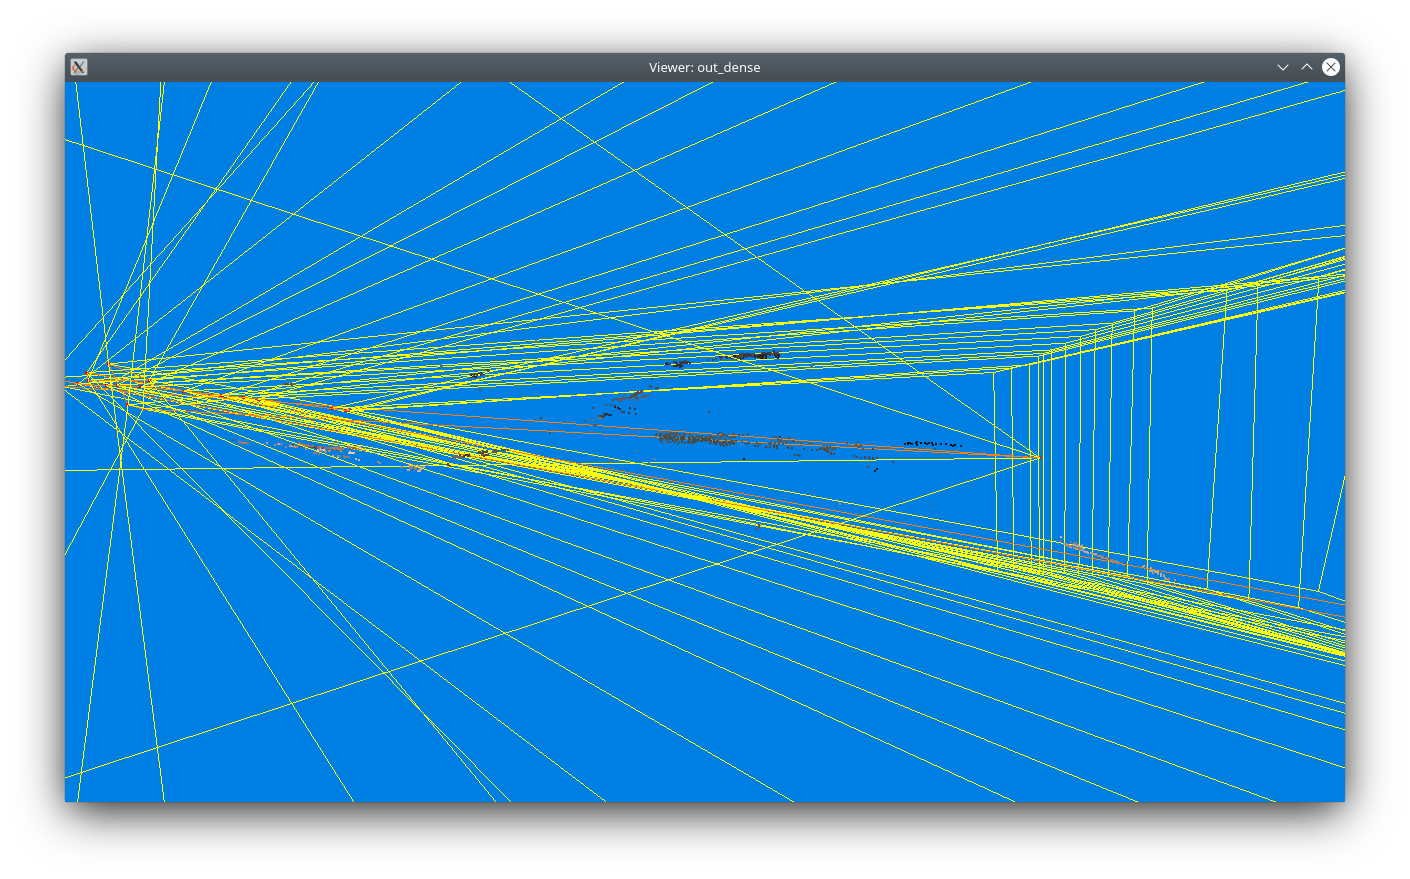

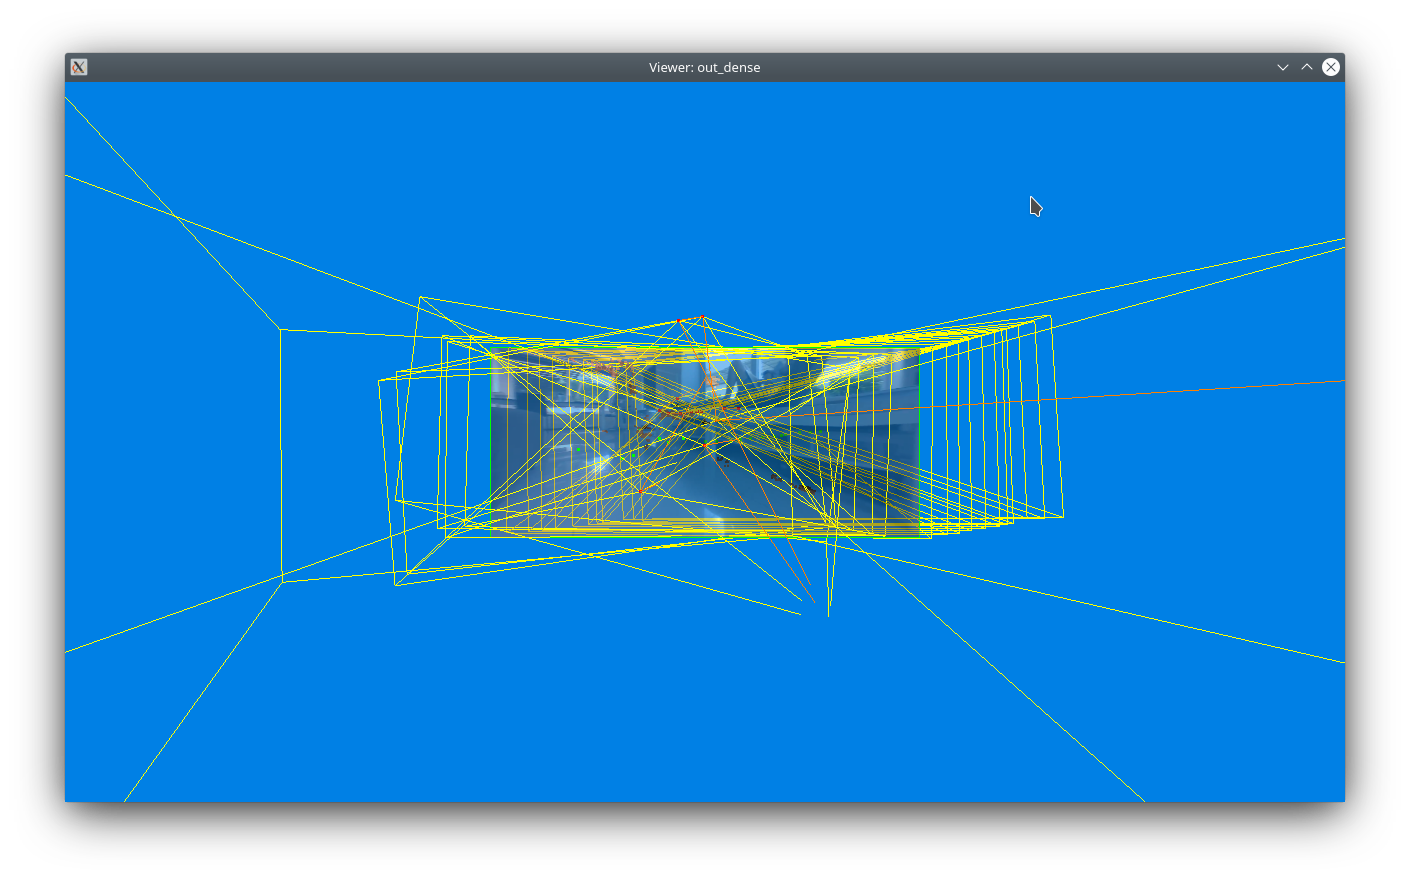

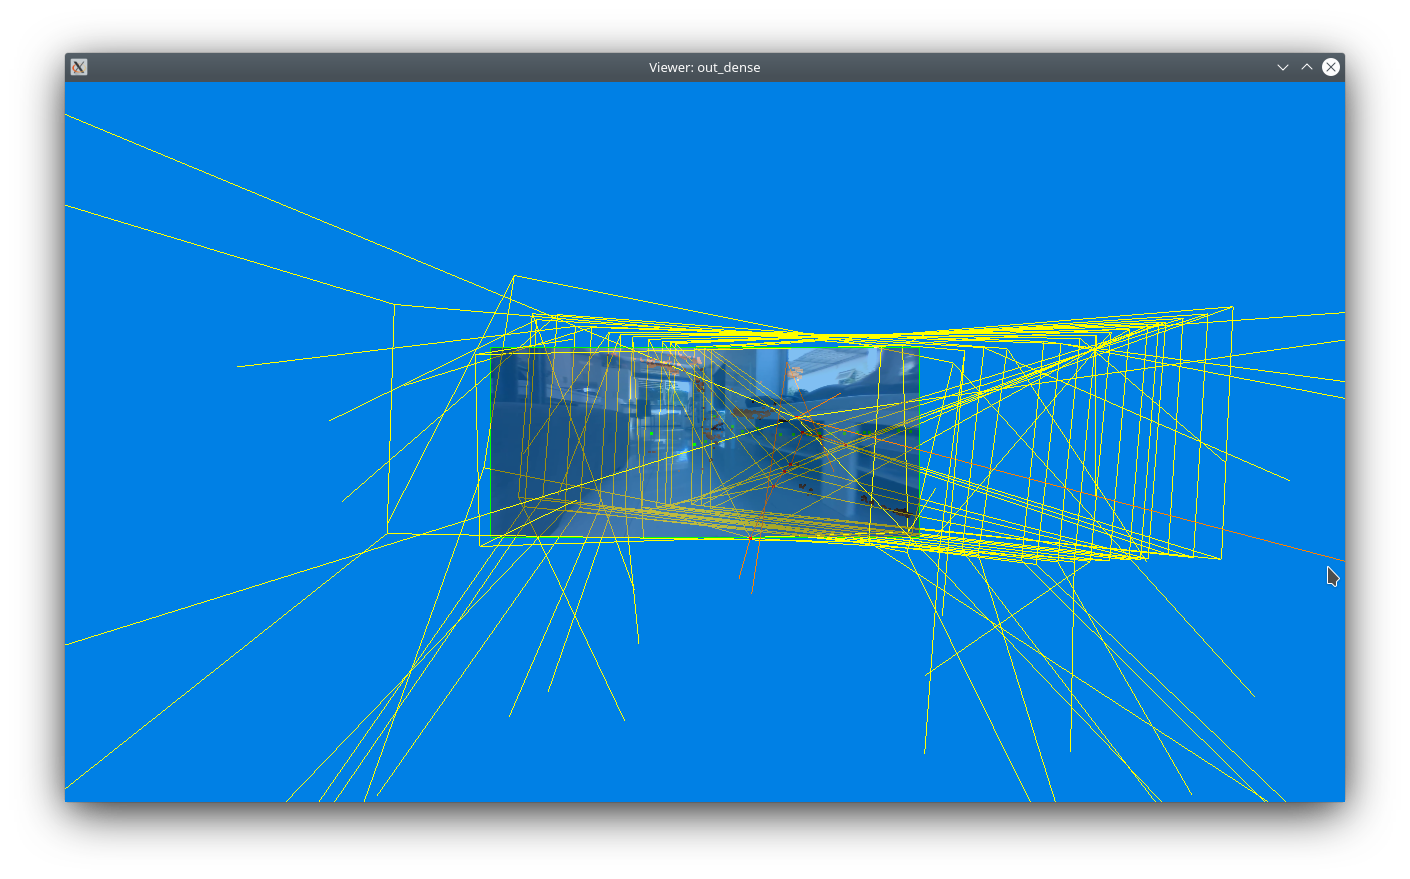

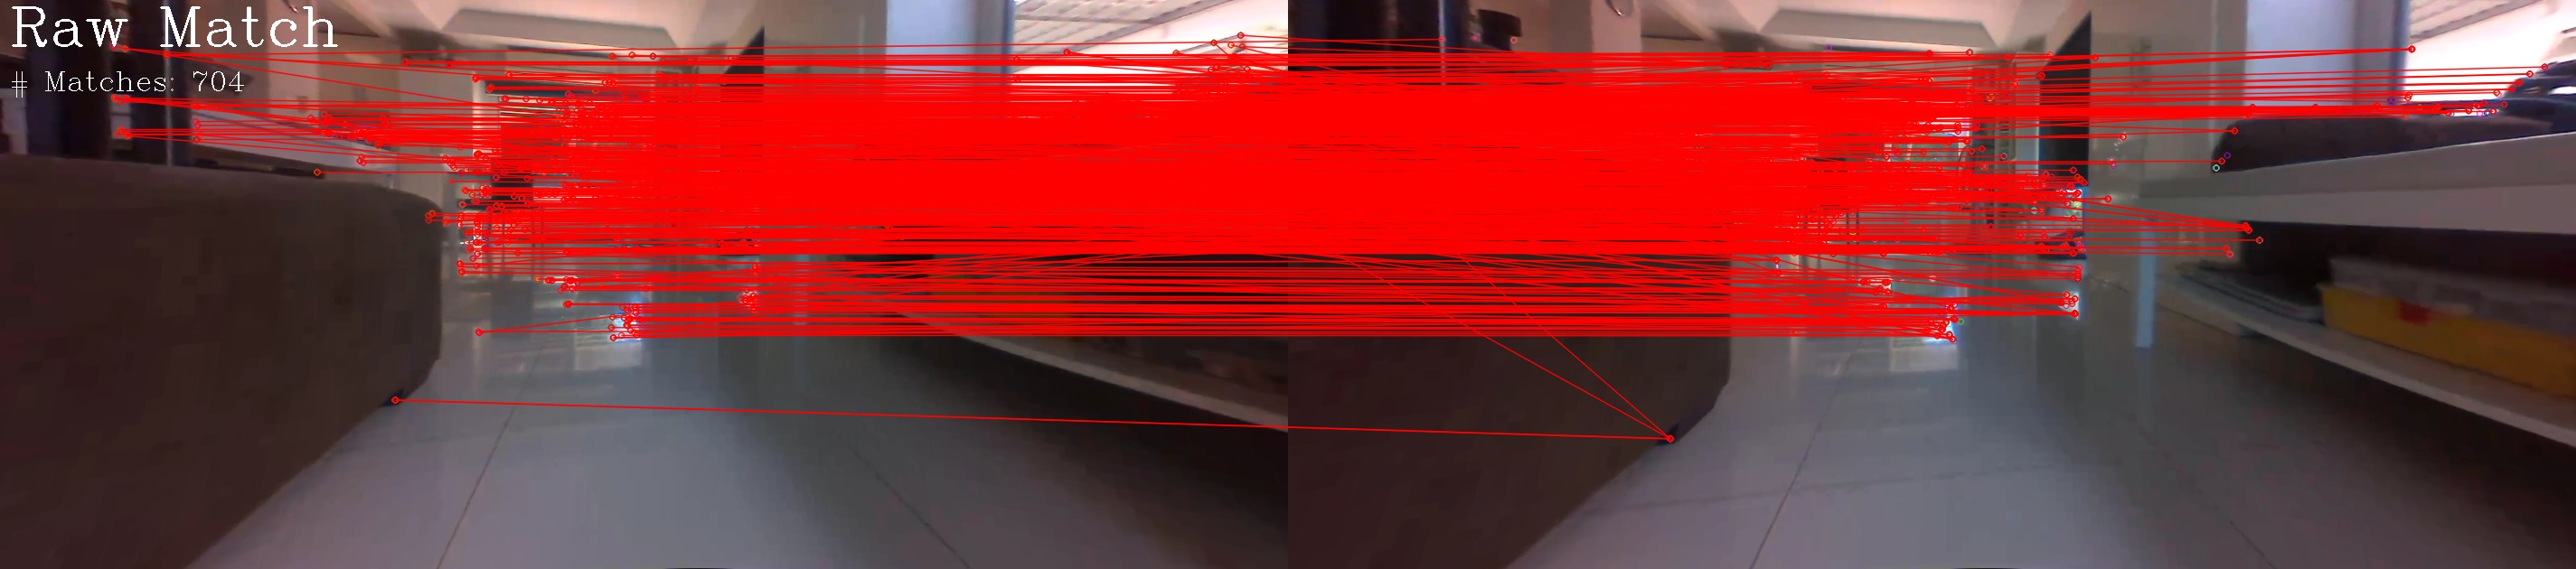

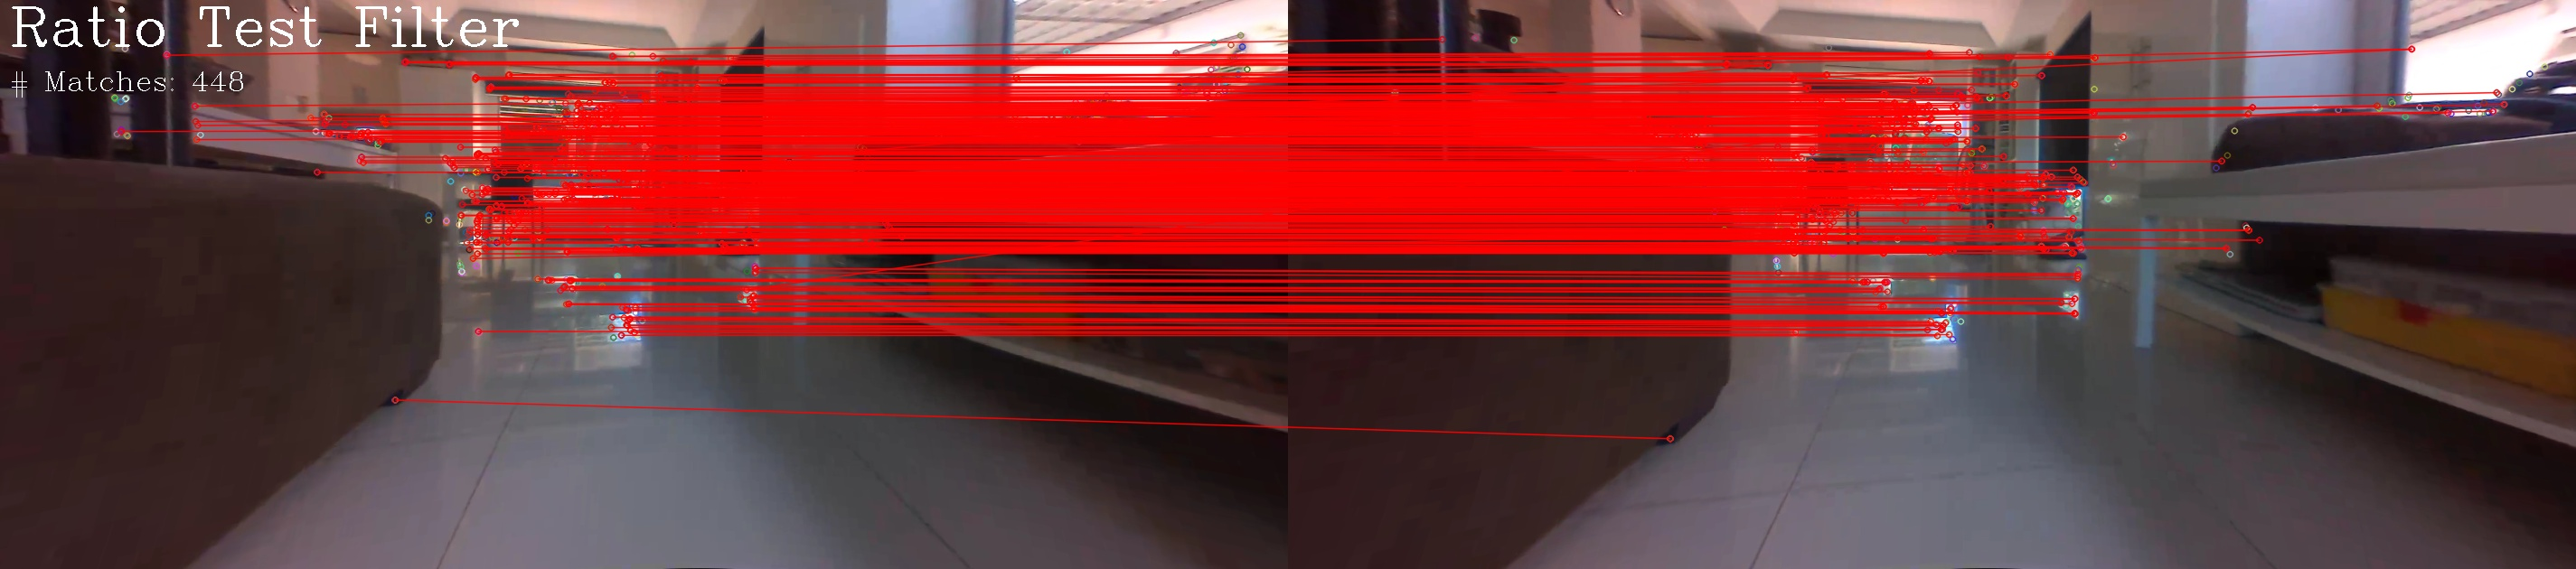

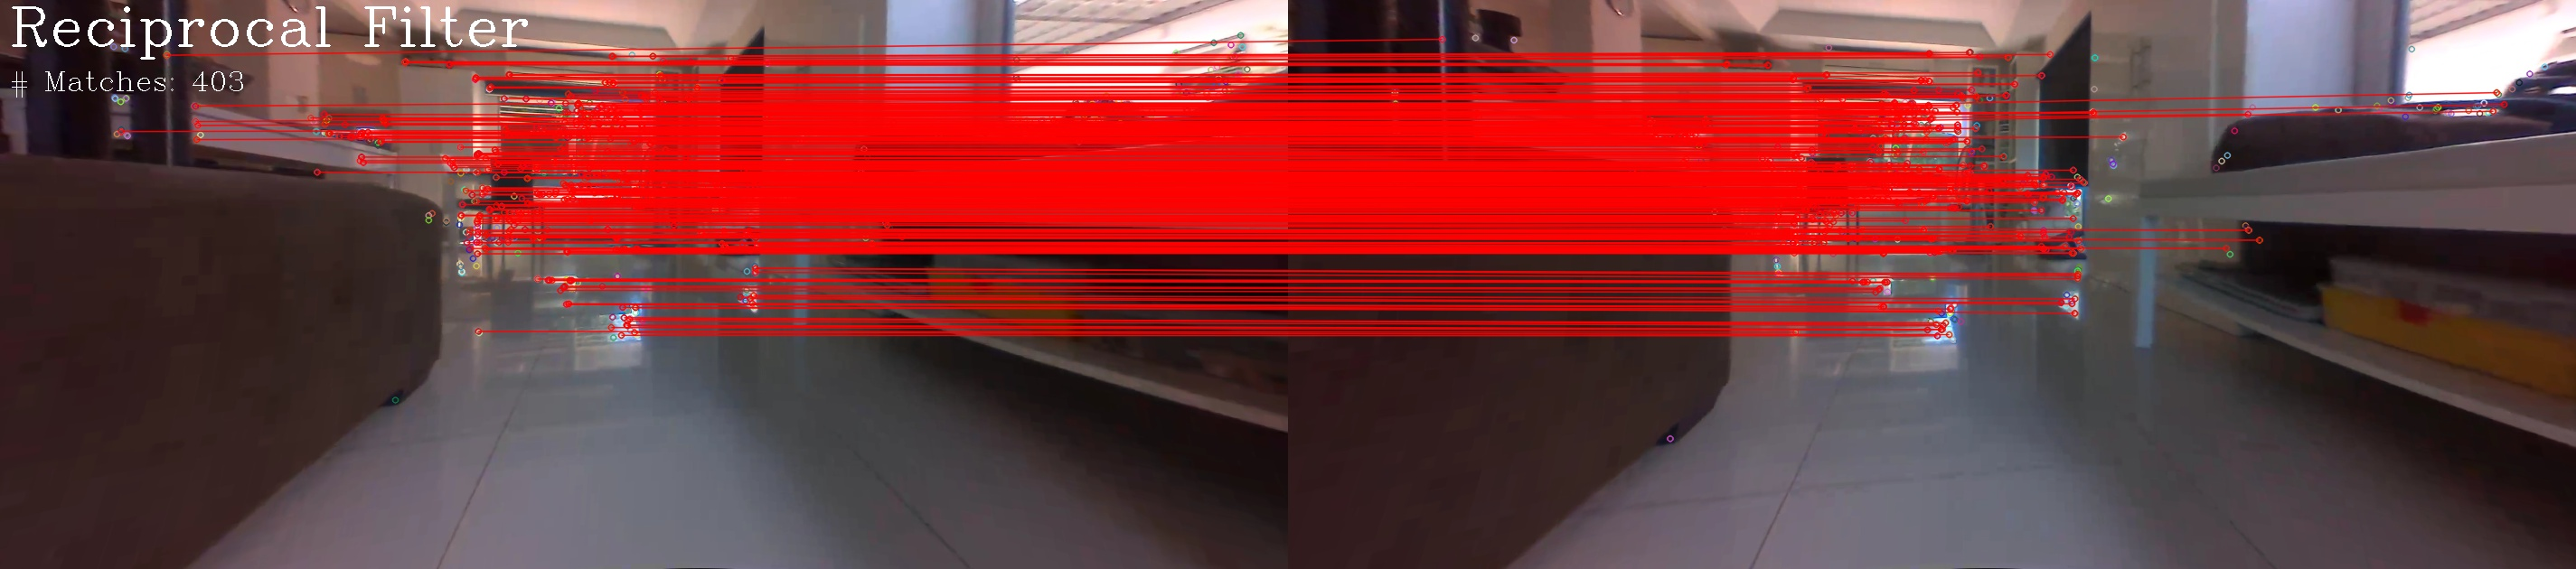

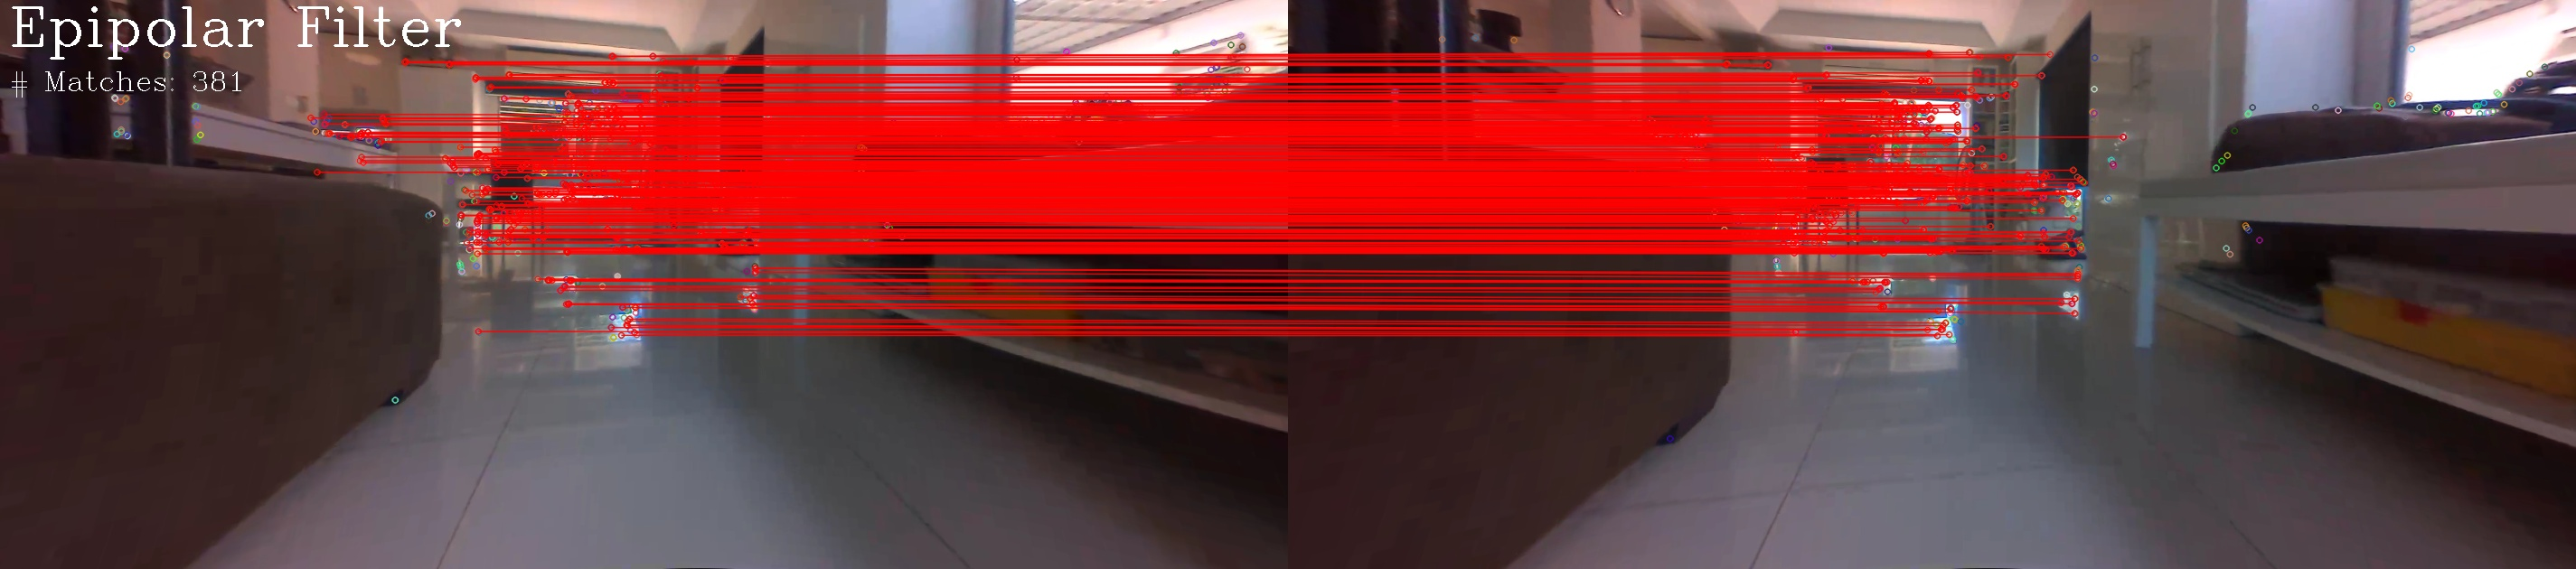

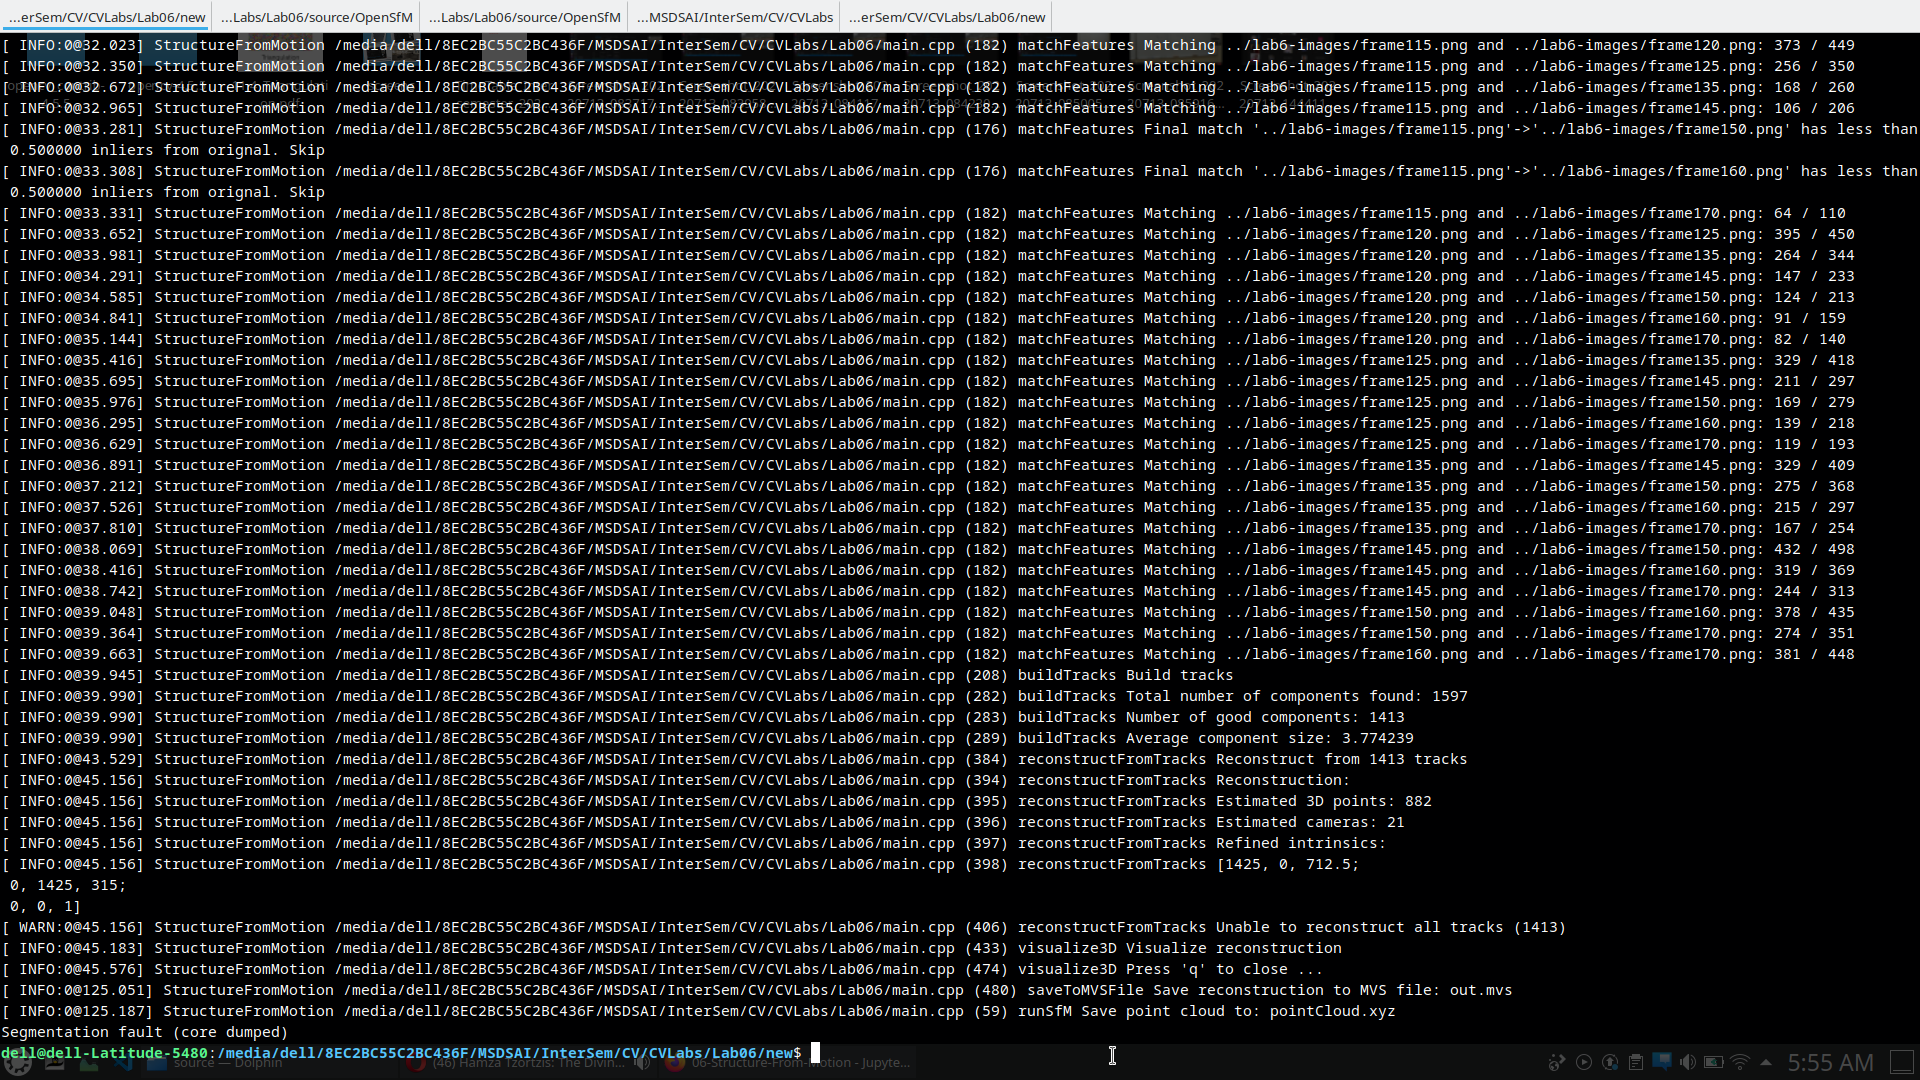